# Compare Auxtel Fitted Spectra and comparison with Merra2

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-03-26
- last update : 2024-03-26
- affiliation : IJCLab/IN2P3/CNRS

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 

import h5py
from scipy import interpolate
from astropy.time import Time
import re
import seaborn as sns
import os

In [2]:
import matplotlib.ticker
%matplotlib inline
#%matplotlib ipympl

In [3]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
# SMOOTHING

def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)


# Read pandas Series

In [5]:
files_spectra_dir = [ "./Data_Auxtel_Spectro/selected_27sep-07dec2023/spectra_transmission_ratio"]
def get_spectra_path(nightobs):
    return files_spectra_dir[0]


In [6]:

files = [ "Data_Auxtel_Spectro/selected_27sep-07dec2023/out_allfittedparams_selected_27sept-07dec2023.csv", 
        ]
N = len(files)

In [7]:
all_df = [pd.read_csv(files[idx], index_col=0, header=0) for idx in range(N)]

In [8]:
df = pd.concat(all_df)

In [9]:
df.head()

id  BITPIX  NAXIS  NAXIS1  \
DATE-OBS                                                                    
2023-09-28 00:17:22.483504618+00:00  2023092700216     -64      2    1137   
2023-09-28 00:30:05.168006009+00:00  2023092700238     -64      2    1136   
2023-09-28 01:09:07.731001435+00:00  2023092700282     -64      2    1137   
2023-09-28 01:10:20.660995968+00:00  2023092700283     -64      2    1137   
2023-09-28 01:17:58.019506853+00:00  2023092700290     -64      2    1136   

                                     NAXIS2  EXTEND    TARGET  REDSHIFT  \
DATE-OBS                                                                  
2023-09-28 00:17:22.483504618+00:00       3    True  HD200654 -0.000149   
2023-09-28 00:30:05.168006009+00:00       3    True  HD200654 -0.000149   
2023-09-28 01:09:07.731001435+00:00       3    True  HD185975 -0.000065   
2023-09-28 01:10:20.660995968+00:00       3    True  HD185975 -0.000065   
2023-09-28 01:17:58.019506853+00:00       3    True  HD200654 -0.000149   

                                       GRATING  ROTANGLE  ...  PWV [mm]_err_y  \
DATE-OBS                                                  ...                   
2023-09-28 00:17:22.483504618+00:00  holo4_003  0.156740  ...        0.093474   
2023-09-28 00:30:05.168006009+00:00  holo4_003  0.107565  ...        0.000000   
2023-09-28 01:09:07.731001435+00:00  holo4_003  0.139774  ...        0.095193   
2023-09-28 01:10:20.660995968+00:00  holo4_003  0.129744  ...        0.029050   
2023-09-28 01:17:58.019506853+00:00  holo4_003  0.161290  ...        0.043695   

                                     reso [nm]  reso [nm]_err  D_CCD [mm]_y  \
DATE-OBS                                                                      
2023-09-28 00:17:22.483504618+00:00   1.178870       0.050612    187.329946   
2023-09-28 00:30:05.168006009+00:00   0.100000       0.000000    186.116726   
2023-09-28 01:09:07.731001435+00:00   1.023278       0.031357    187.098508   
2023-09-28 01:10:20.660995968+00:00   2.311433       0.040625    186.989090   
2023-09-28 01:17:58.019506853+00:00   2.610434       0.063734    186.780868   

                                     D_CCD [mm]_err_y  alpha_pix [pix]  \
DATE-OBS                                                                 
2023-09-28 00:17:22.483504618+00:00          0.011312         0.078592   
2023-09-28 00:30:05.168006009+00:00          0.000000         0.000000   
2023-09-28 01:09:07.731001435+00:00          0.005137         1.128498   
2023-09-28 01:10:20.660995968+00:00          0.006061         1.115322   
2023-09-28 01:17:58.019506853+00:00          0.010390         1.164272   

                                     alpha_pix [pix]_err  B_y  B_err_y  \
DATE-OBS                                                                 
2023-09-28 00:17:22.483504618+00:00                  0.0  0.0      0.0   
2023-09-28 00:30:05.168006009+00:00                  0.0  0.0      0.0   
2023-09-28 01:09:07.731001435+00:00                  0.0  0.0      0.0   
2023-09-28 01:10:20.660995968+00:00                  0.0  0.0      0.0   
2023-09-28 01:17:58.019506853+00:00                  0.0  0.0      0.0   

                                     filtered  
DATE-OBS                                       
2023-09-28 00:17:22.483504618+00:00      True  
2023-09-28 00:30:05.168006009+00:00     False  
2023-09-28 01:09:07.731001435+00:00      True  
2023-09-28 01:10:20.660995968+00:00      True  
2023-09-28 01:17:58.019506853+00:00      True  

[5 rows x 171 columns]

In [10]:
for name in list(df.columns):
    print(name)

id
BITPIX
NAXIS
NAXIS1
NAXIS2
EXTEND
TARGET
REDSHIFT
GRATING
ROTANGLE
D2CCD
LSHIFT
PARANGLE
TARGETX
TARGETY
LBDA_REF
PSF_REG
TRACE_R
MEANFWHM
PIXSHIFT
CHI2_FIT
A2_FIT
AM_FIT
VERSION
CCD_REBIN
CONFIG
EXPTIME
AIRMASS
DEC
HA
OUTTEMP
OUTPRESS
OUTHUM
FILTER
CAM_ROT
S_X0
S_Y0
S_XMIN
S_XMAX
S_YMIN
S_YMAX
S_NX
S_NY
S_DEG
S_SAT
S_ORDER
A1_x
A1_err_x
A2_x
A2_err_x
A3
A3_err
VAOD_x
VAOD_err_x
angstrom_exp_x
angstrom_exp_err_x
ozone [db]_x
ozone [db]_err_x
PWV [mm]_x
PWV [mm]_err_x
D_CCD [mm]_x
D_CCD [mm]_err_x
shift_x [pix]
shift_x [pix]_err
shift_y [pix]
shift_y [pix]_err
angle [deg]
angle [deg]_err
B_x
B_err_x
A_star
A_star_err
x_c_0_1
x_c_0_1_err
x_c_1_1
x_c_1_1_err
x_c_2_1
x_c_2_1_err
y_c_0_1
y_c_0_1_err
y_c_1_1
y_c_1_1_err
y_c_2_1
y_c_2_1_err
gamma_0_1
gamma_0_1_err
gamma_1_1
gamma_1_1_err
gamma_2_1
gamma_2_1_err
alpha_0_1
alpha_0_1_err
alpha_1_1
alpha_1_1_err
alpha_2_1
alpha_2_1_err
saturation_0_1
saturation_0_1_err
x_c_0_2
x_c_0_2_err
x_c_1_2
x_c_1_2_err
x_c_2_2
x_c_2_2_err
y_c_0_2
y_c_0_2

In [11]:
def convertNumToDatestr(num):
    year = num//1000_000_000
    month= (num-year*1000_000_000)//10_000_000
    day = (num-year*1000_000_000-month*10_000_000)//100_000

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)
    #return datestr

In [12]:
print(df.id.values)

[2023092700216 2023092700238 2023092700282 2023092700283 2023092700290
 2023092700291 2023092700298 2023092700299 2023092700309 2023092700310
 2023092700326 2023092700327 2023092700334 2023092700335 2023092700342
 2023092700343 2023092700350 2023092700351 2023092700358 2023092700359
 2023092700382 2023092700383 2023092700390 2023092700391 2023092700398
 2023092700399 2023092700406 2023092700407 2023092700414 2023092700415
 2023092700422 2023092700423 2023092700430 2023092700431 2023092700438
 2023092700439 2023092700446 2023092700447 2023092700455 2023092700462
 2023092700463 2023092700470 2023092700471 2023092700478 2023092700479
 2023092700505 2023092800160 2023092800161 2023092800168 2023092800169
 2023092800176 2023092800177 2023092800184 2023092800185 2023092800192
 2023092800193 2023092800200 2023092800201 2023092800222 2023092800226
 2023092800227 2023092800234 2023092800235 2023092800242 2023092800243
 2023092800250 2023092800251 2023092800258 2023092800259 2023092800266
 20230

In [13]:
df['nightobs'] = df.id.values//100_000

In [14]:
df['dateobs']=[convertNumToDatestr(num) for num in df.id.values ]

## Remove non Photometric Nights

In [15]:
NonPhotometricNights = [20240131]

In [16]:
PhotometricNightSelector  = lambda x : True if x not in NonPhotometricNights else False

In [17]:
df['PhotometricNight_Flag'] = df['nightobs'].apply(PhotometricNightSelector)

In [18]:
df = df[df['PhotometricNight_Flag']].drop(['PhotometricNight_Flag'],axis=1)

## Check Spectra quality

In [19]:
df1 = df
#df2 = df[(df['nightobs']>=20230301) & (df['nightobs']<=20230914)]
#df3 = df[(df['nightobs']>=20230927) & (df['nightobs']<=20231207)]

In [20]:
print("df1 : ",df1.nightobs.unique())
#print("df2 : ",df2.nightobs.unique())
#print("df3 : ",df3.nightobs.unique())

df1 :  [20230927 20230928 20231010 20231107 20231108 20231113 20231114 20231115
 20231116 20231120 20231127 20231128 20231129 20231130 20231204 20231205
 20231206 20231207]


In [21]:
def get_all_data_fromhf(hf):

    def get_attrs(name,obj):
        d = {}
        for key, val in obj.attrs.items():
            d[key] = val
        return d
    
    all_attributes = {}
    all_datasets = {}
    list_of_keys = list(hf.keys())

    # loop on each key of top level groups
    for key in list_of_keys: 
        group = hf.get(key)
    
        # retrieve all attributes for each group
        all_attributes[key] = get_attrs(key,group)

        datasets = {}
        for name, h5obj in group.items():
            if isinstance(h5obj,h5py.Group):
                pass
                # just check if there are subgroups that would need to be red recursively
                #print("\t >>> ",key,' / ',name,'is a Group')
         
            elif isinstance(h5obj,h5py.Dataset):
                #print("\t >>> ", key , name,'is a Dataset')
                arr = h5obj[:]
                #arr = hf[name][:] # same thing
                # add that dataset to the current group datasets
                datasets[name] = arr
    
        all_datasets[key] = datasets  
    return  list_of_keys, all_attributes ,all_datasets

In [22]:
def ShowDCCD(hf,nightobs,df_in):
    """
    """
    dfi = df_in.copy()
    
    def convertNumToDatestr2(num):
        year = num//10_000
        month= (num-year*10_000)//100
        day = (num-year*10_000-month*100)

        year_str = str(year).zfill(4)
        month_str = str(month).zfill(2)
        day_str = str(day).zfill(2)
    
        datestr = f"{year_str}-{month_str}-{day_str}"
        return datestr

    DATEOBS_STR = convertNumToDatestr2(nightobs)

    # retrieve all data from the hdf file
    list_of_keys, all_attributes ,all_datasets = get_all_data_fromhf(hf)

    # the data with their sequence number
    spec_nums_list = ["spec_" + re.findall("^spec_(.*)", keyname)[0] for keyname in list_of_keys if len(re.findall("^spec_(.*)", keyname)) > 0 ] 


    # targets
    all_targets = []
    textstr2 = ''

    for idx,spec_num in enumerate(spec_nums_list):
        the_attrs = all_attributes[spec_num]
        the_target = the_attrs['target']
        tag = re.findall("^spec_(.*)", spec_num)[0]
        tag= int(tag)
       
        the_DCCD = dfi[dfi["id"] == tag ]['D_CCD [mm]_y'].values[0]
        print(spec_num,nightobs,DATEOBS_STR,the_DCCD)

In [23]:
df_subset = df[["id","D_CCD [mm]_y"]]

In [24]:
#df_subset[df_subset["id"] == 2024012900323]["D_CCD [mm]_y"].values[0]

In [25]:
df_subset.copy()

id  D_CCD [mm]_y
DATE-OBS                                                        
2023-09-28 00:17:22.483504618+00:00  2023092700216    187.329946
2023-09-28 00:30:05.168006009+00:00  2023092700238    186.116726
2023-09-28 01:09:07.731001435+00:00  2023092700282    187.098508
2023-09-28 01:10:20.660995968+00:00  2023092700283    186.989090
2023-09-28 01:17:58.019506853+00:00  2023092700290    186.780868
...                                            ...           ...
2023-12-08 03:14:06.988503349+00:00  2023120700399    186.990988
2023-12-08 03:43:37.521992488+00:00  2023120700420    186.835182
2023-12-08 03:44:50.441503941+00:00  2023120700421    186.935022
2023-12-08 04:02:32.741498325+00:00  2023120700434    186.934967
2023-12-08 04:03:45.754501796+00:00  2023120700435    186.851084

[492 rows x 2 columns]

In [26]:
for nightobs in df1.nightobs.unique():
    path = get_spectra_path(nightobs)
    filename = f"spectra_transmission_ratio_{nightobs}.h5"
    fullfilename = os.path.join(path,filename)
    try:  
        hf = h5py.File(fullfilename, 'r')
        ShowDCCD(hf,nightobs,df_subset.copy())
        hf.close()
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        

spec_2023092700283 20230927 2023-09-27 186.98909004341036
spec_2023092700290 20230927 2023-09-27 186.78086757700464
spec_2023092700291 20230927 2023-09-27 186.95014778391504
spec_2023092700309 20230927 2023-09-27 187.0197245827588
spec_2023092700343 20230927 2023-09-27 187.041410070146
spec_2023092700358 20230927 2023-09-27 186.8695220359595
spec_2023092700359 20230927 2023-09-27 186.98453297649965
spec_2023092700406 20230927 2023-09-27 186.98232644945853
spec_2023092700407 20230927 2023-09-27 186.88622470125847
spec_2023092700414 20230927 2023-09-27 187.024006132612
spec_2023092700430 20230927 2023-09-27 186.93299331220229
spec_2023092700431 20230927 2023-09-27 186.98384115084565
spec_2023092700438 20230927 2023-09-27 186.9551907837398
spec_2023092700439 20230927 2023-09-27 186.98711699569415
spec_2023092700447 20230927 2023-09-27 186.9873279761382
spec_2023092700462 20230927 2023-09-27 186.83814705284183
spec_2023092800161 20230928 2023-09-28 186.81310718322035
spec_2023092800176 202

In [27]:
def PlotTransmission(hf,nightobs,df_in):

    dfi = df_in.copy()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    def convertNumToDatestr2(num):
        year = num//10_000
        month= (num-year*10_000)//100
        day = (num-year*10_000-month*100)

        year_str = str(year).zfill(4)
        month_str = str(month).zfill(2)
        day_str = str(day).zfill(2)
    
        datestr = f"{year_str}-{month_str}-{day_str}"
        return datestr

    DATEOBS_STR = convertNumToDatestr2(nightobs)

    # retrieve all data from the hdf file
    list_of_keys, all_attributes ,all_datasets = get_all_data_fromhf(hf)

    # the data with their sequence number
    spec_nums_list = ["spec_" + re.findall("^spec_(.*)", keyname)[0] for keyname in list_of_keys if len(re.findall("^spec_(.*)", keyname)) > 0 ] 


    # targets
    all_targets = []
    textstr2 = ''

    for idx,spec_num in enumerate(spec_nums_list):
        the_attrs = all_attributes[spec_num]
        the_target = the_attrs['target']
        tag = re.findall("^spec_(.*)", spec_num)[0]
        tag= int(tag)
        the_DCCD = dfi[dfi.id == tag ]['D_CCD [mm]_y'].values[0]
        print(spec_num,the_DCCD)
        info = f"{nightobs} :: {spec_num} , tg = {the_target} Dccd = {the_DCCD:.2f}"
        textstr2 = '\n'.join((textstr2,info))
        all_targets.append(the_target)
    
    targets_unique = np.unique(all_targets)
    Ntags = len(targets_unique )
    cmap = sns.color_palette("husl", Ntags)

    #text string
    atm = all_attributes['median_param_atm']
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    textstr = '\n'.join((
    r'$PWV=%.3f$ mm' % (atm["md_PWV"], ),
    r'$ozone=%.1f$ DU' % (atm["md_ozone"], ),
    r'$VAOD=%.3f$' % (atm['md_VAOD'], )))
    
    # plot
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8),sharex=True)

    color_counts = np.zeros(Ntags)

    # loop on data
    for idx,spec_num in enumerate(spec_nums_list):
        the_dataset = all_datasets[spec_num]
        the_attrs = all_attributes[spec_num]
        the_target = the_attrs['target']

        the_label = the_target

        idxc = np.where(targets_unique== the_target )[0][0]
        the_col = cmap[idxc]
    
 
        all_targets.append(the_target)
        the_airmass = the_attrs['airmass']
        the_flag = the_attrs['flag_atmparam']
        the_title = f"{spec_num} , target = {the_target}"
    
   
        wls = the_dataset['wls']
        fls = the_dataset['fls']
        fls_err = the_dataset['fls_err']

        ratio_airmass1 = the_dataset['ratio_airmass1']
        wlr = the_dataset['wlr']

        span=3
        ratio_airmass2 = smooth_data_np_convolve(ratio_airmass1,span)
        
        if color_counts[idxc] == 0:
            ax1.plot(wls,fls,'-', color= the_col,label = the_label)
            ax2.plot(wlr,ratio_airmass2,'-', color= the_col,label=the_label)
            color_counts[idxc] = color_counts[idxc]+1
        else:
            ax1.plot(wls,fls,'-', color= the_col)
            ax2.plot(wlr,ratio_airmass2,'-', color= the_col)
            color_counts[idxc] = color_counts[idxc]+1

        
    # the simulation
    the_sim = all_datasets['sim_spec']
    transm = the_sim["transm"] 
    wls = the_sim["wls"] 
    ax2.plot(wls,transm,'k',label="simulation")
    ax2.text(0.75, 0.25, textstr, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
   
    ax2.set_ylim(0.,1.2)  
    ax1.legend()  
    ax2.legend()
    ax1.set_title(f"{DATEOBS_STR}")
    ax1.set_xlim(370.,980.)
    ax2.set_xlabel("wavelength (nm)")
    ax1.set_ylabel("flux (ergs/cm$^2$/s/nm)")
    ax2.set_ylabel("atmospheric transmission")
    ax1.text(1.1, 1.0, textstr2, transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        #plt.tight_layout()
    ax1.grid()
    ax2.grid()
    plt.subplots_adjust(wspace=None, hspace=0)
    plt.show()

### Check quality in nights in df1 

spec_2023092700283 186.98909004341036
spec_2023092700290 186.78086757700464
spec_2023092700291 186.95014778391504
spec_2023092700309 187.0197245827588
spec_2023092700343 187.041410070146
spec_2023092700358 186.8695220359595
spec_2023092700359 186.98453297649965
spec_2023092700406 186.98232644945853
spec_2023092700407 186.88622470125847
spec_2023092700414 187.024006132612
spec_2023092700430 186.93299331220229
spec_2023092700431 186.98384115084565
spec_2023092700438 186.9551907837398
spec_2023092700439 186.98711699569415
spec_2023092700447 186.9873279761382
spec_2023092700462 186.83814705284183


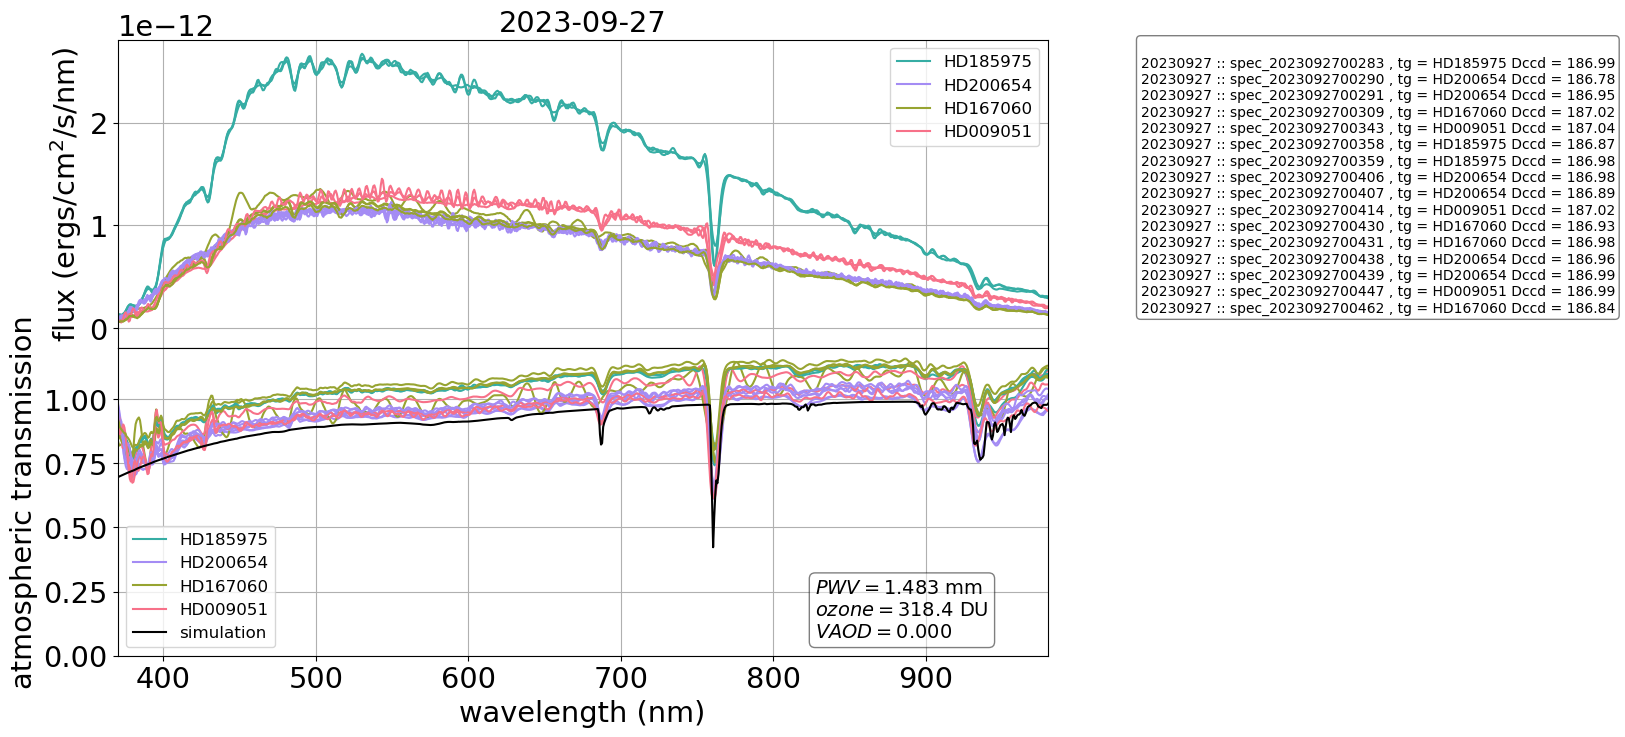

spec_2023092800161 186.81310718322035
spec_2023092800176 186.90534108123543
spec_2023092800184 187.0006324042525
spec_2023092800200 187.0529285499784
spec_2023092800226 186.8993639771535
spec_2023092800227 186.7606603815667
spec_2023092800275 186.97647761793743
spec_2023092800282 186.97415234943853
spec_2023092800283 186.9468283935224
spec_2023092800298 186.8538188108003
spec_2023092800340 186.85411125662333
spec_2023092800341 186.81536824304075
spec_2023092800356 186.94853119834693
spec_2023092800357 186.85135841772967


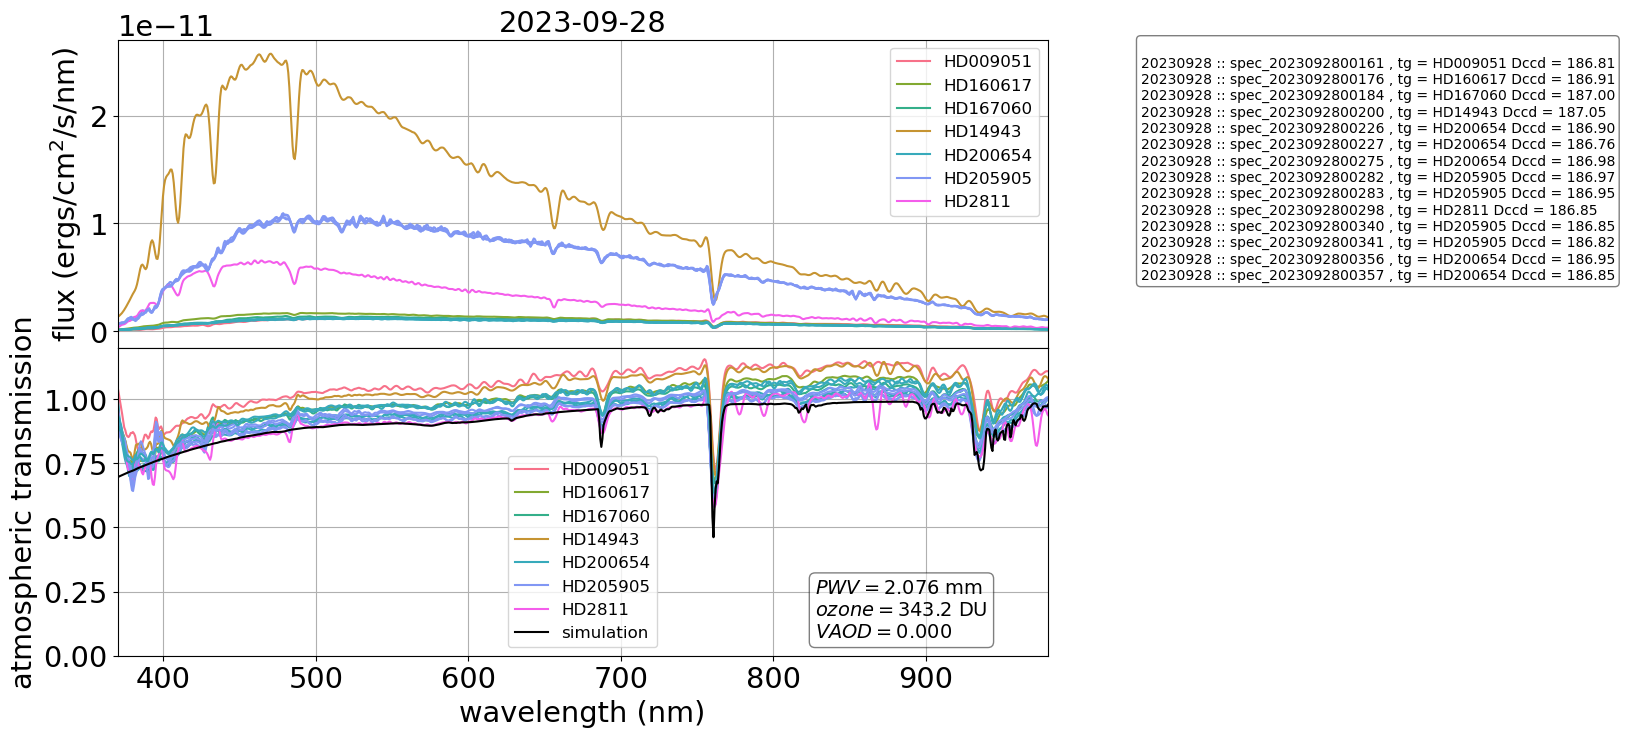

spec_2023101000351 186.7849078002405
spec_2023101000358 186.9288019094973
spec_2023101000371 186.83028384573757
spec_2023101000378 186.9358145049436
spec_2023101000396 186.77461591908624
spec_2023101000397 186.9585648370181
spec_2023101000403 186.8517208693469
spec_2023101000404 186.80964455256375
spec_2023101000438 186.82890184860952
spec_2023101000443 186.9543323707988
spec_2023101000450 186.83462275335577
spec_2023101000464 186.8897641520531
spec_2023101000465 186.77496807243872
spec_2023101000507 186.8522889161084
spec_2023101000515 186.8210135355072
spec_2023101000521 186.8108276879684
spec_2023101000536 186.79572141659324
spec_2023101000542 186.88785276911656
spec_2023101000543 186.956263395041
spec_2023101000557 186.9316733112716
spec_2023101000571 186.7360765796905
spec_2023101000609 186.75674069780615
spec_2023101000610 186.80288321497548
spec_2023101000630 186.9152578232112
spec_2023101000631 186.80999908723084
spec_2023101000638 186.9669965646344


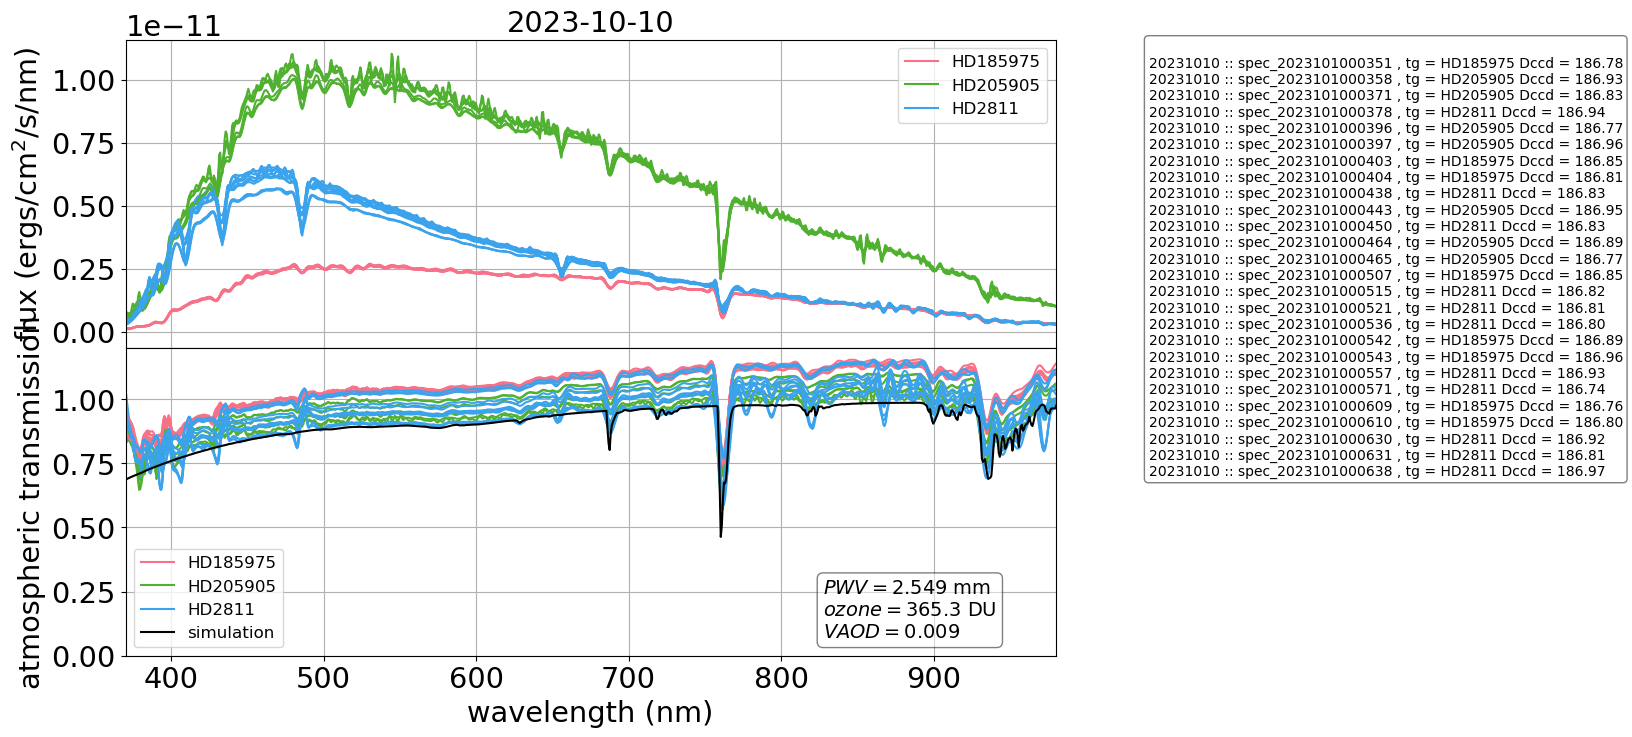

spec_2023110700377 186.9181345139404
spec_2023110700378 186.90291234971235
spec_2023110700426 187.02419797531283
spec_2023110700427 187.00211673534463
spec_2023110700433 186.9002731503824
spec_2023110700434 186.92775999799449
spec_2023110700439 187.00469912004587
spec_2023110700440 186.90529248457025
spec_2023110700452 186.9938999682396
spec_2023110700453 186.8770248845586
spec_2023110700486 186.91048340318844
spec_2023110700487 186.965312682634
spec_2023110700493 186.9511637386716
spec_2023110700494 186.77711843801976
spec_2023110700500 186.9985563220993
spec_2023110700501 186.9990067221281
spec_2023110700530 186.89973083775527
spec_2023110700556 186.8592942181059
spec_2023110700571 186.8337950957944


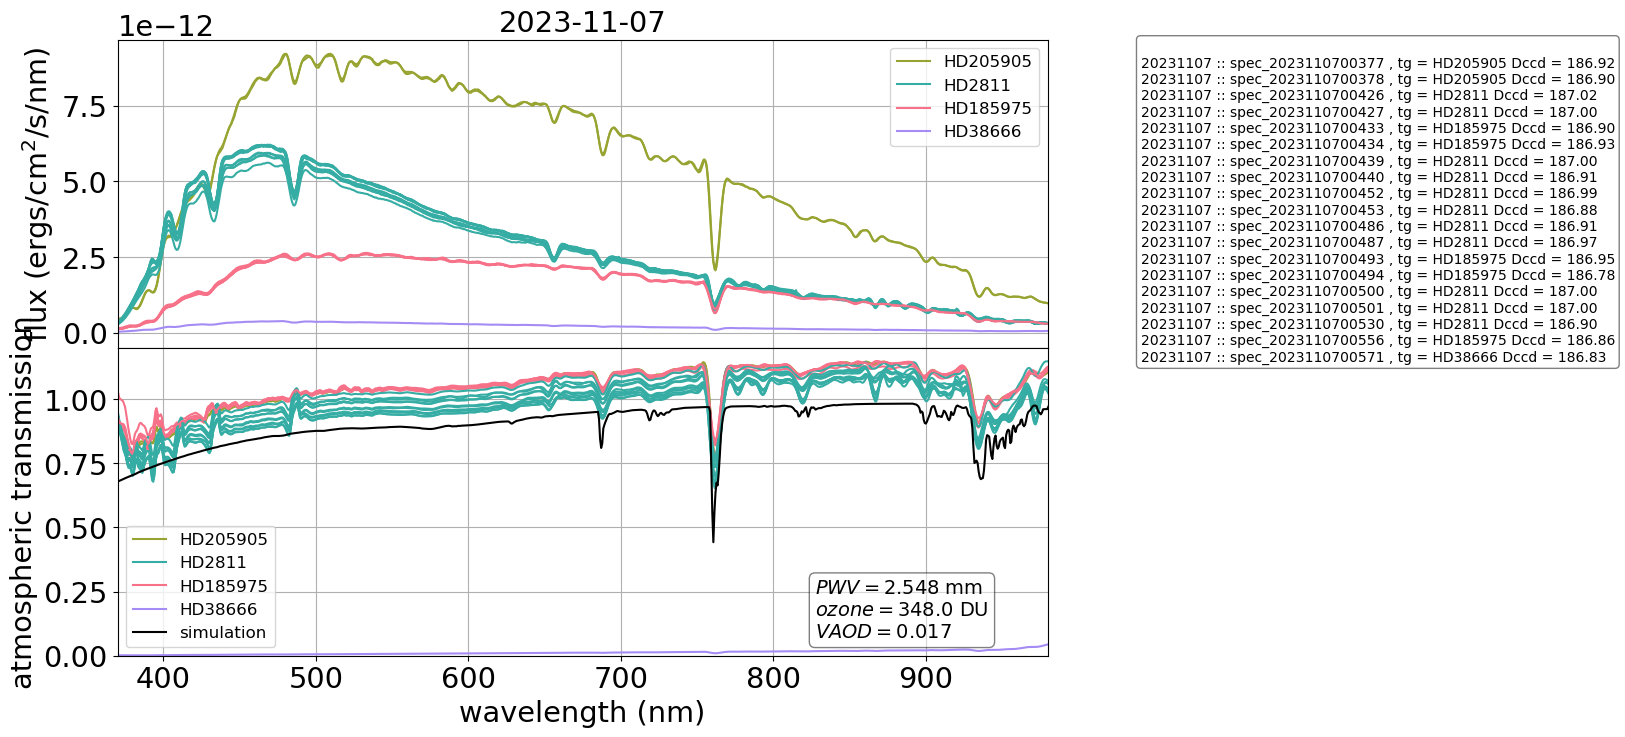

spec_2023110800379 186.9950317102772
spec_2023110800390 186.91939428126585
spec_2023110800391 186.89336876128817


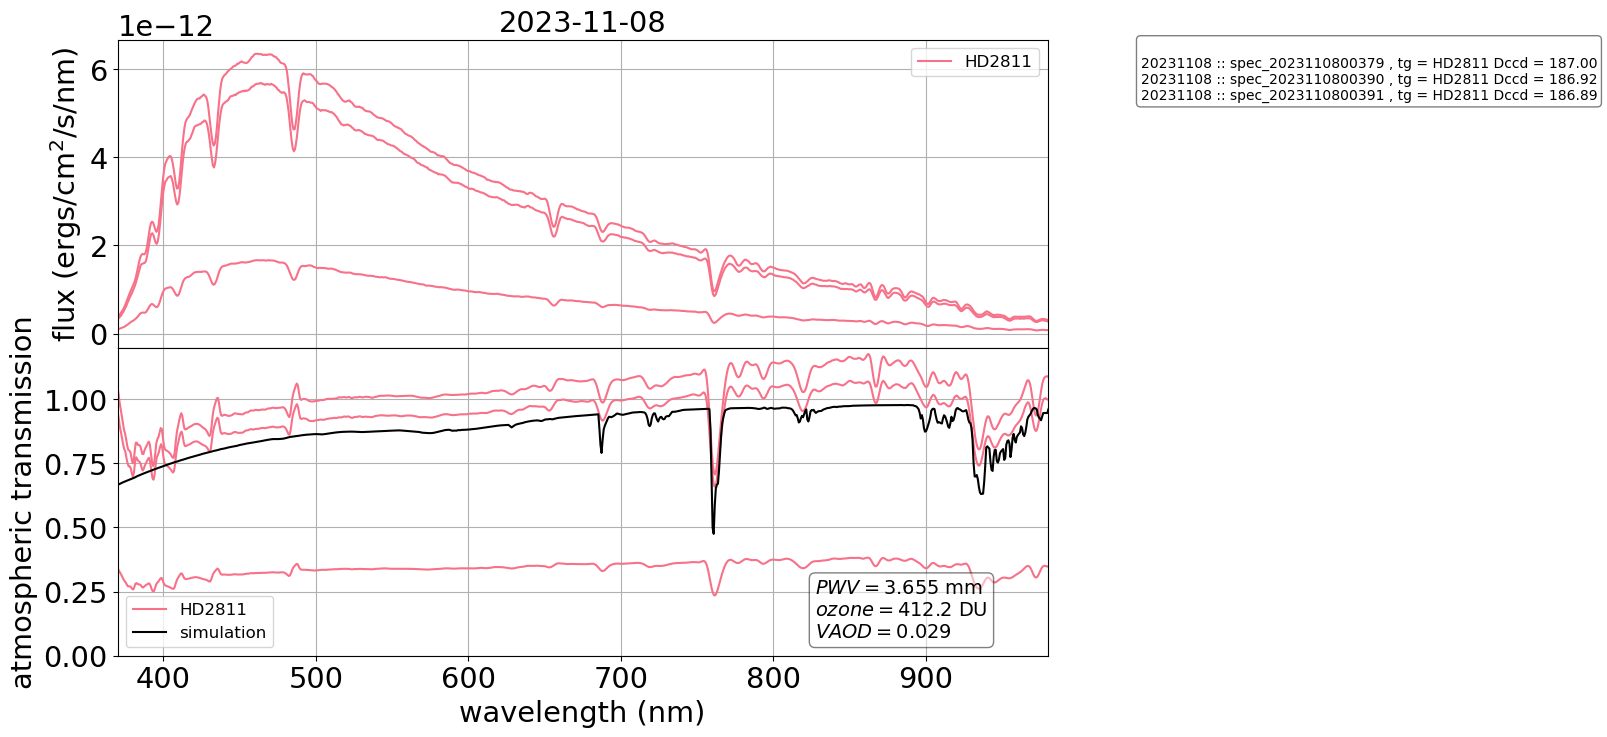

spec_2023111300251 186.8921266586061
spec_2023111300252 186.77757764862812
spec_2023111300260 186.74841754457609
spec_2023111300261 186.8027184713036
spec_2023111300285 186.7861985033517
spec_2023111300286 186.7957678642781
spec_2023111300292 186.9232322531137
spec_2023111300293 187.0030000331923
spec_2023111300300 186.93558643454816
spec_2023111300309 186.8531477446595


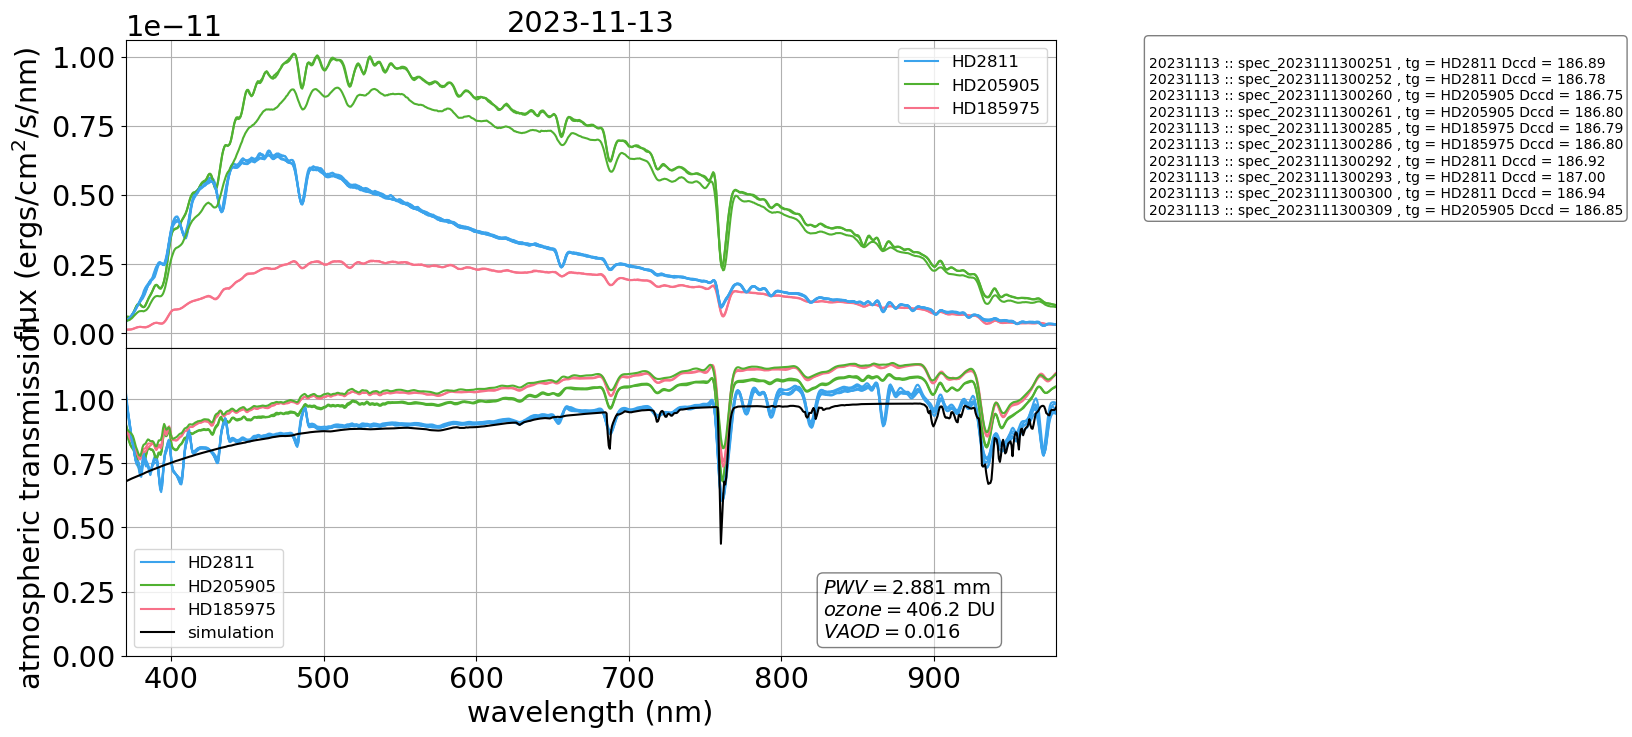

spec_2023111400345 186.926549164564
spec_2023111400346 186.83003313773963
spec_2023111400353 186.94226800745983
spec_2023111400366 186.7899687777596
spec_2023111400367 186.8056064862959
spec_2023111400392 186.7889773556666
spec_2023111400393 186.77385473456027
spec_2023111400405 186.79092173304332
spec_2023111400430 186.8498180513512
spec_2023111400437 186.79030631108057
spec_2023111400445 186.8275291190432
spec_2023111400446 186.96947226762447


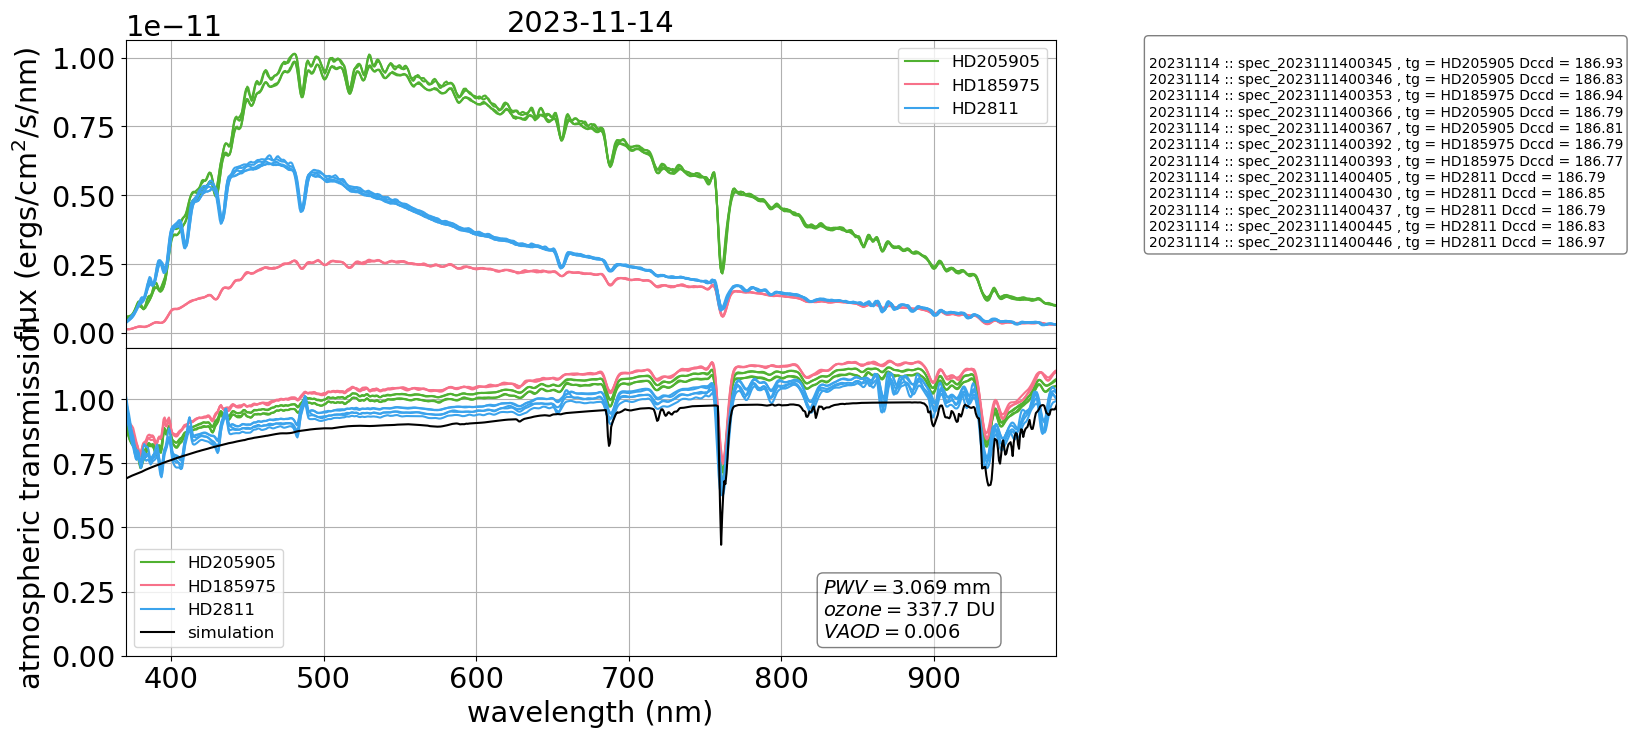

spec_2023111500285 186.81132341137533
spec_2023111500317 186.7665723215261
spec_2023111500345 186.89957253692728
spec_2023111500346 186.8852144536869
spec_2023111500398 186.8721666980587
spec_2023111500399 186.9273381958773
spec_2023111500405 186.9203830968299
spec_2023111500406 186.9237882031382
spec_2023111500419 186.8630324880785
spec_2023111500433 186.91382354056012
spec_2023111500434 186.992894322596
spec_2023111500447 186.92747443466152
spec_2023111500448 186.83650834748389
spec_2023111500466 186.7469627748195
spec_2023111500467 186.8603380344962


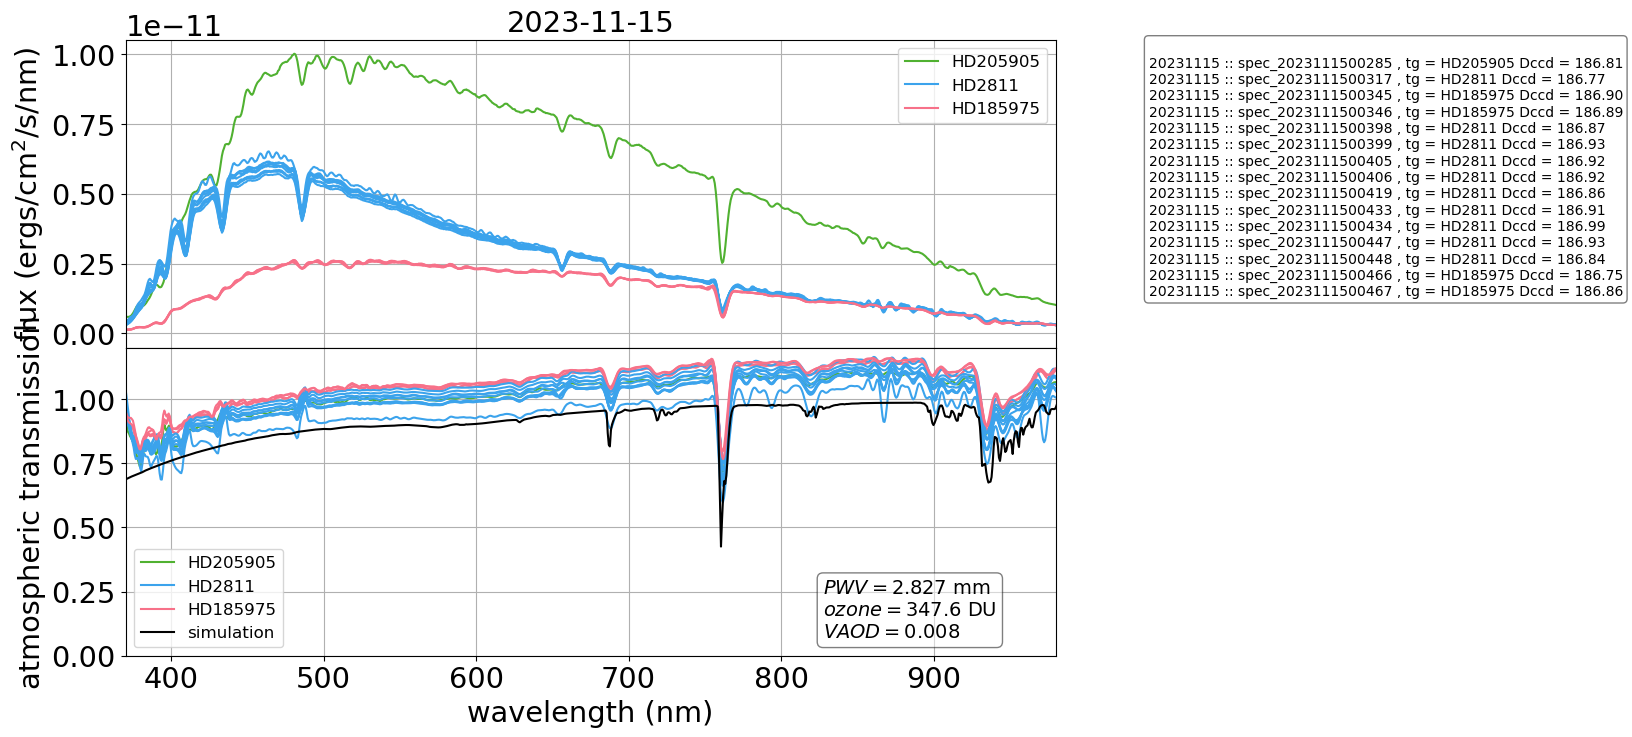

spec_2023111600437 186.78429905112924
spec_2023111600492 186.82196878957575
spec_2023111600506 186.89733193980305
spec_2023111600513 186.91206847680743
spec_2023111600514 186.8196071774397
spec_2023111600534 186.89286028617536
spec_2023111600548 186.81352300982869
spec_2023111600598 186.87491211893803
spec_2023111600612 186.8996843159877
spec_2023111600613 186.8676150205999


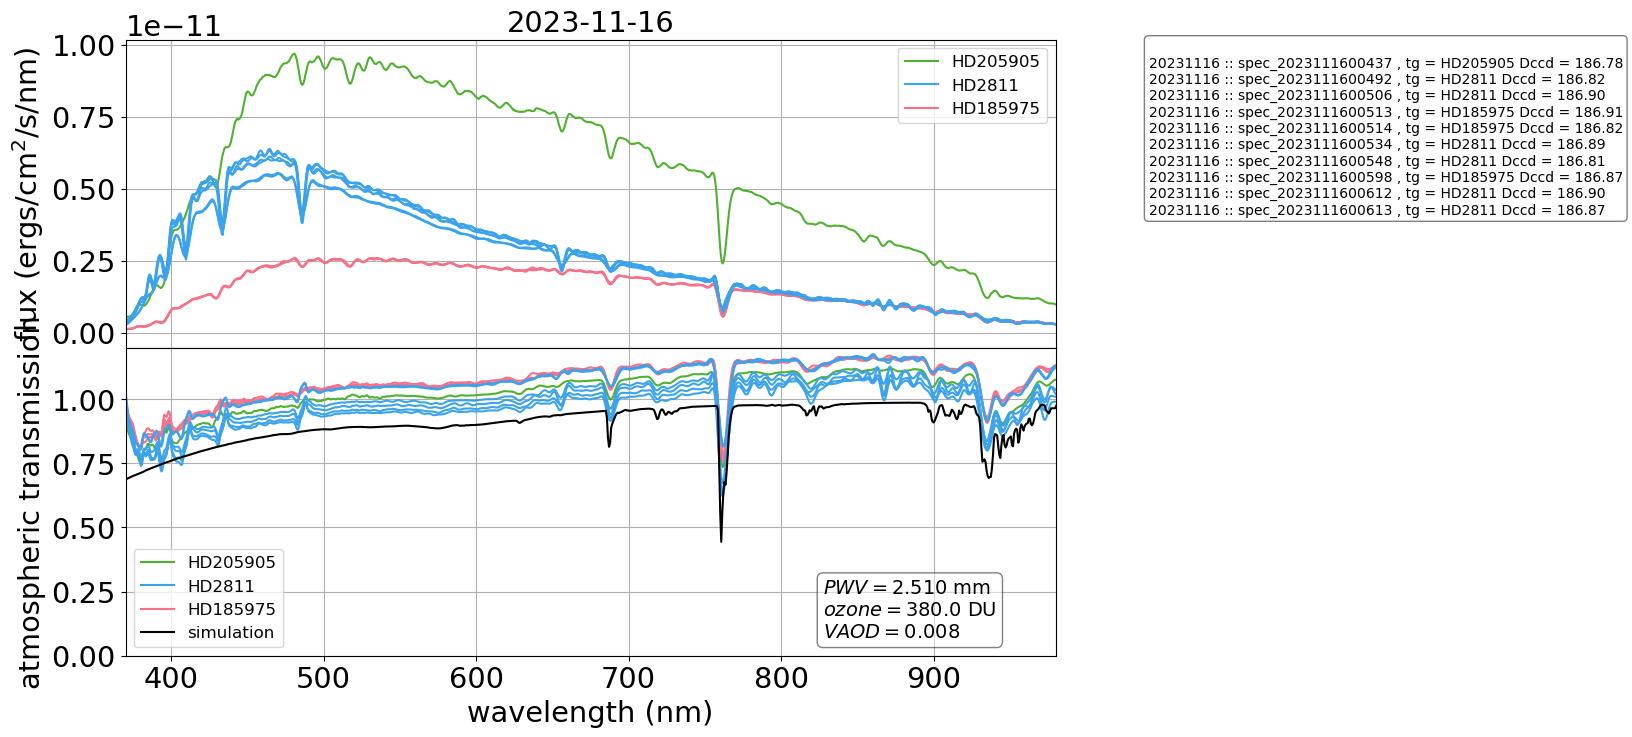

spec_2023112000082 186.9479458380162
spec_2023112000083 186.90311770040736
spec_2023112000113 186.95752819299992
spec_2023112000114 187.4066890740207
spec_2023112000163 186.8705062359232
spec_2023112000164 186.95555817750417
spec_2023112000176 186.95506028895457
spec_2023112000189 186.93488187027583
spec_2023112000202 186.98088289830133
spec_2023112000203 186.91860657326583
spec_2023112000209 186.92001311207804
spec_2023112000210 186.88877322987045
spec_2023112000240 186.85534462073187
spec_2023112000266 186.80268563356472


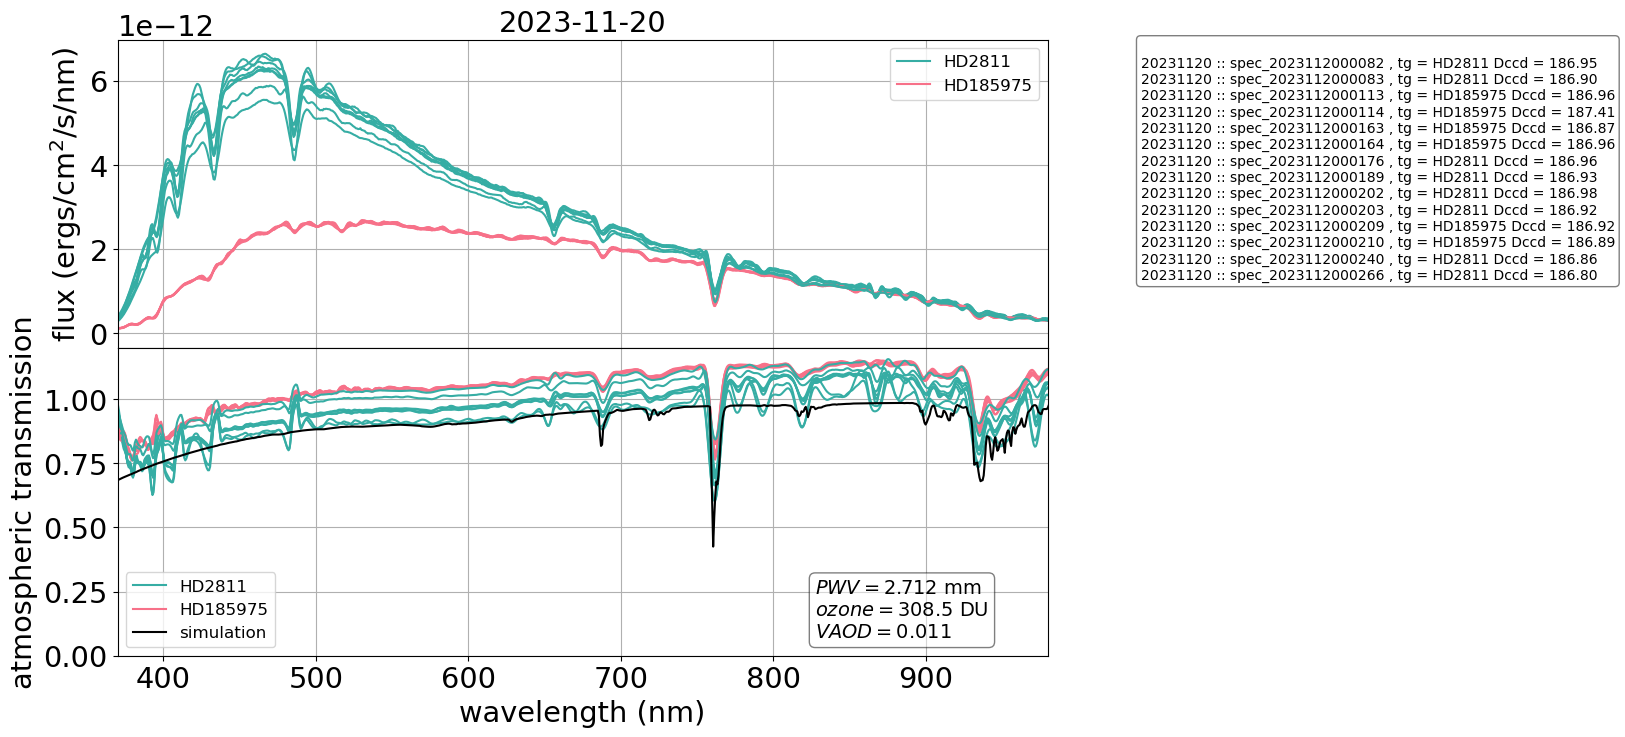

spec_2023112700066 186.8138744484968
spec_2023112700074 186.9135166101286
spec_2023112700080 186.8420774002477
spec_2023112700094 186.8605766142041
spec_2023112700095 186.89797781591065
spec_2023112700116 186.91211269859377
spec_2023112700122 186.89072651145872
spec_2023112700123 186.81467687251808
spec_2023112700148 186.91134482079963
spec_2023112700168 186.94622879620965
spec_2023112700169 186.92983568551347
spec_2023112700175 186.8493071728152
spec_2023112700182 186.79076241942172
spec_2023112700183 186.9546973343556
spec_2023112700196 186.8482807096349
spec_2023112700197 186.92638894876035
spec_2023112700211 186.93407198748503


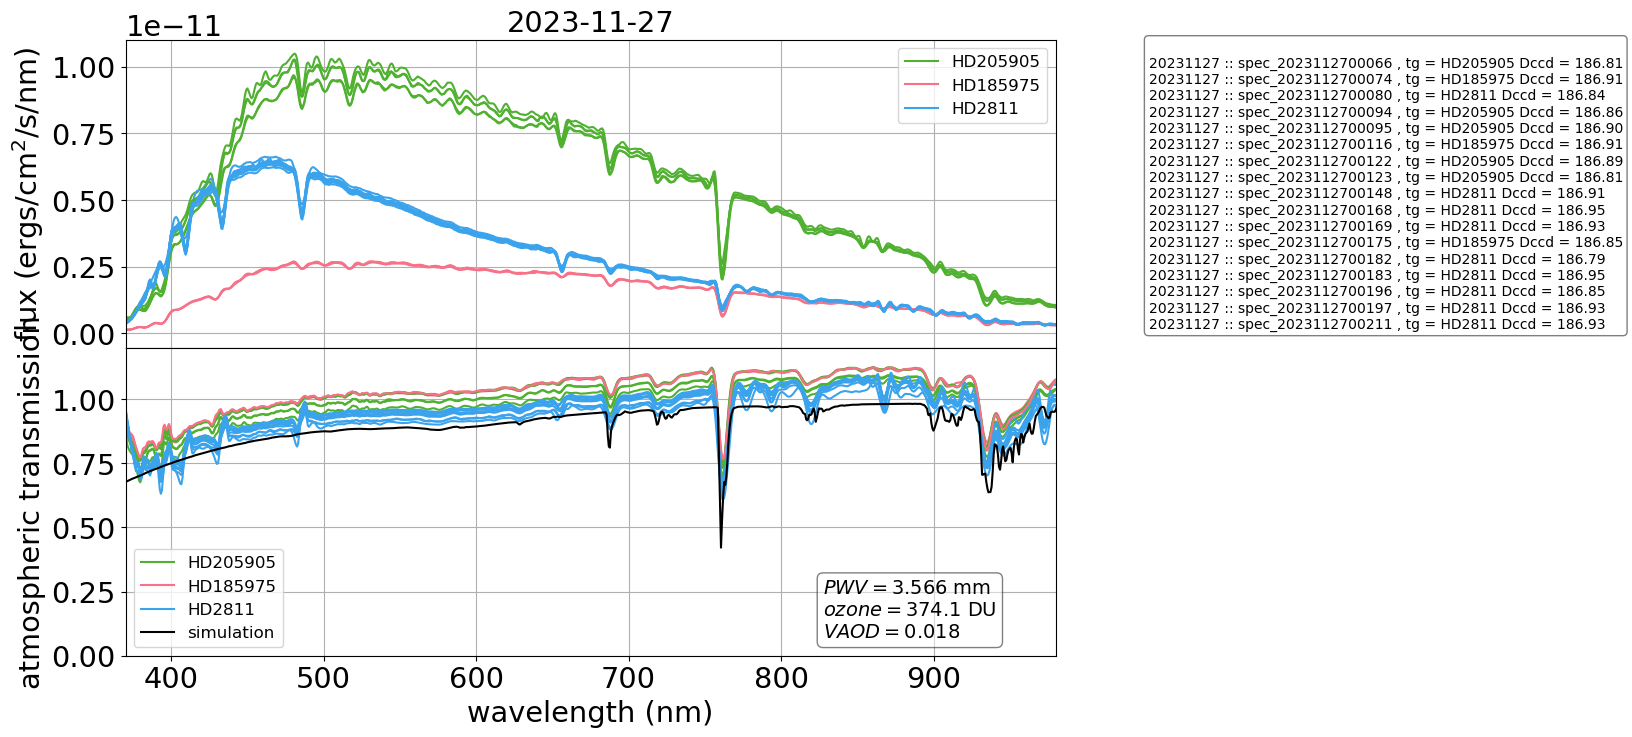

spec_2023112800306 186.93643302561892
spec_2023112800312 186.63326993563345
spec_2023112800313 186.8415374605256
spec_2023112800350 186.87690776521748
spec_2023112800351 186.9153459658784
spec_2023112800396 186.87871046699985
spec_2023112800403 186.99529007032623
spec_2023112800410 186.8566323830431
spec_2023112800438 186.7972269841972
spec_2023112800445 186.9209101708665
spec_2023112800446 186.94261496183805
spec_2023112800452 186.82321270123785
spec_2023112800453 186.85037618019348
spec_2023112800467 186.761002637451
spec_2023112800480 186.7708961856743
spec_2023112800481 186.7814110854416
spec_2023112800487 186.83150925040692
spec_2023112800488 186.89135271470704


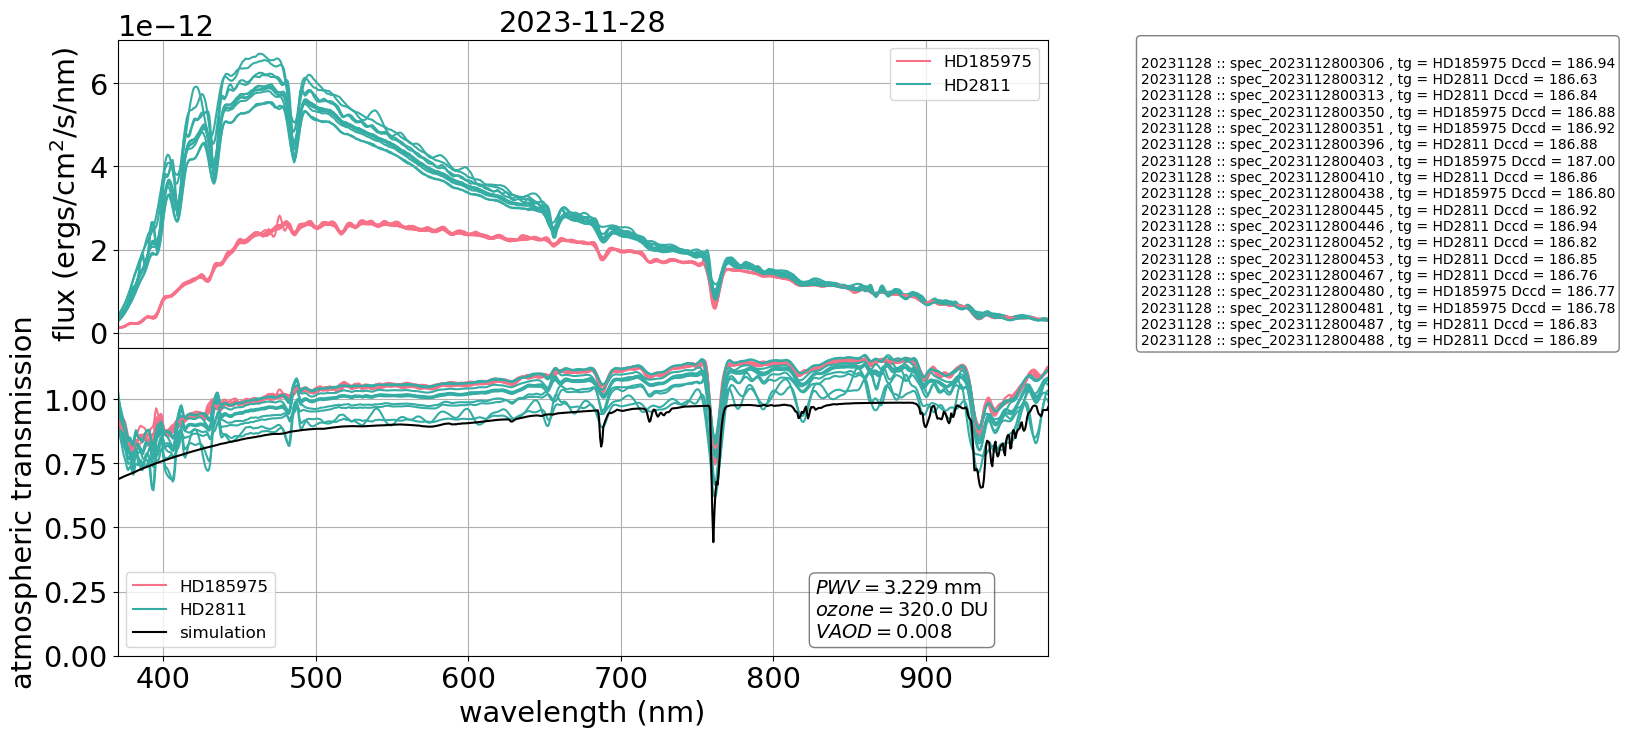

spec_2023112900311 186.90021219483071
spec_2023112900367 186.90603036411696
spec_2023112900373 186.74759304687217
spec_2023112900374 186.77043298059095
spec_2023112900395 186.82202836435667
spec_2023112900436 186.89905307566264
spec_2023112900437 186.9364599284223
spec_2023112900465 186.8785897712224
spec_2023112900493 186.88110339462511
spec_2023112900494 186.87896613238087
spec_2023112900507 186.881372999098


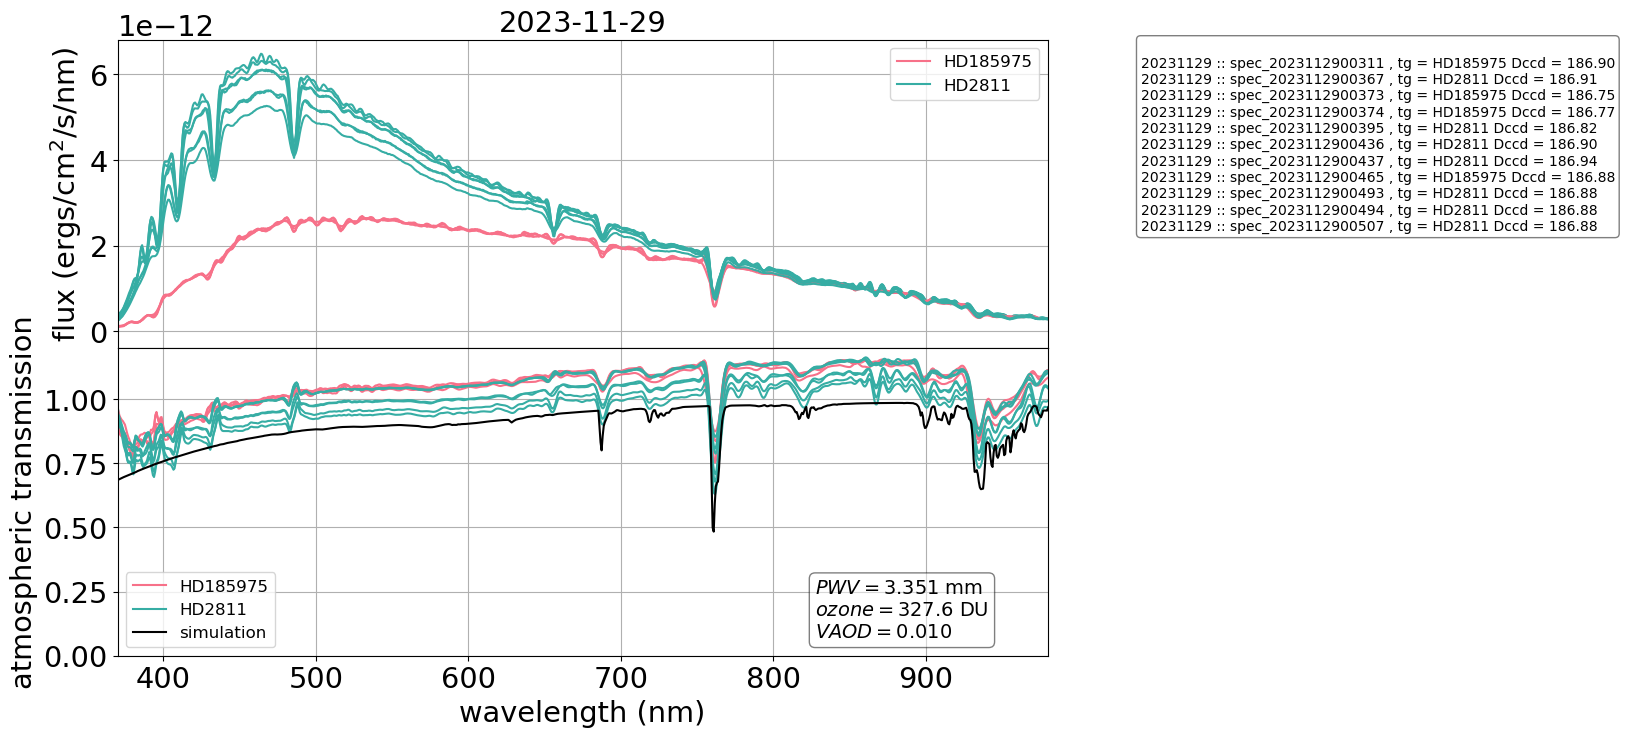

spec_2023113000311 186.79717314373244
spec_2023113000312 186.81114750093832
spec_2023113000318 186.92878805641587
spec_2023113000346 187.4606857675141


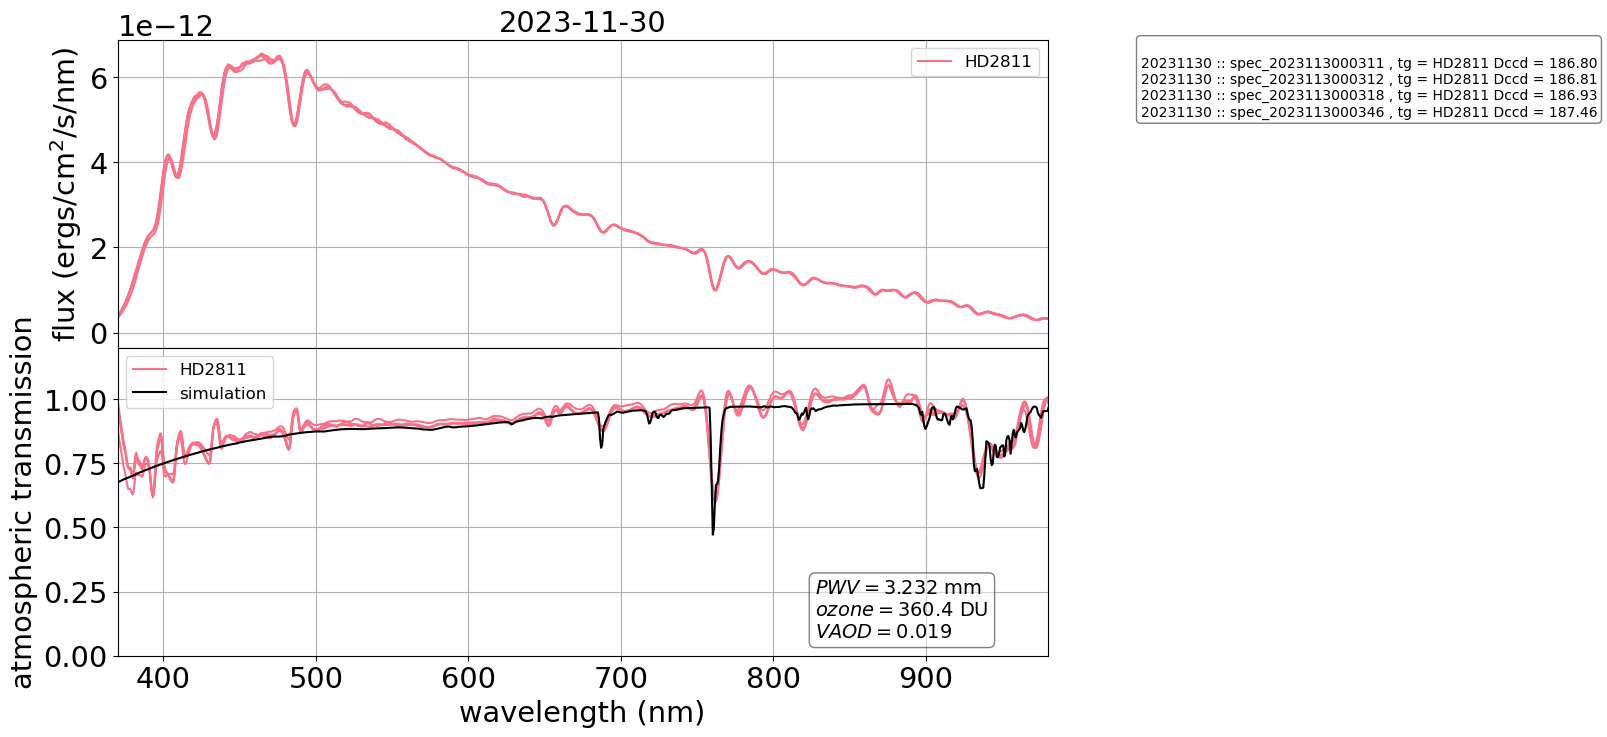

spec_2023120400308 186.83673408716675
spec_2023120400322 186.93401909872856
spec_2023120400379 186.94749057437048
spec_2023120400420 186.7664794366409
spec_2023120400421 186.7907649785832
spec_2023120400434 186.91101152402567
spec_2023120400435 186.9279913286124
spec_2023120400448 186.93782423040597
spec_2023120400449 186.8348915021815
spec_2023120400474 186.9211222019983
spec_2023120400475 186.975654208138
spec_2023120400488 186.7797726115199
spec_2023120400489 186.8691939198927
spec_2023120400623 186.8716058645202
spec_2023120400624 186.87693531277367


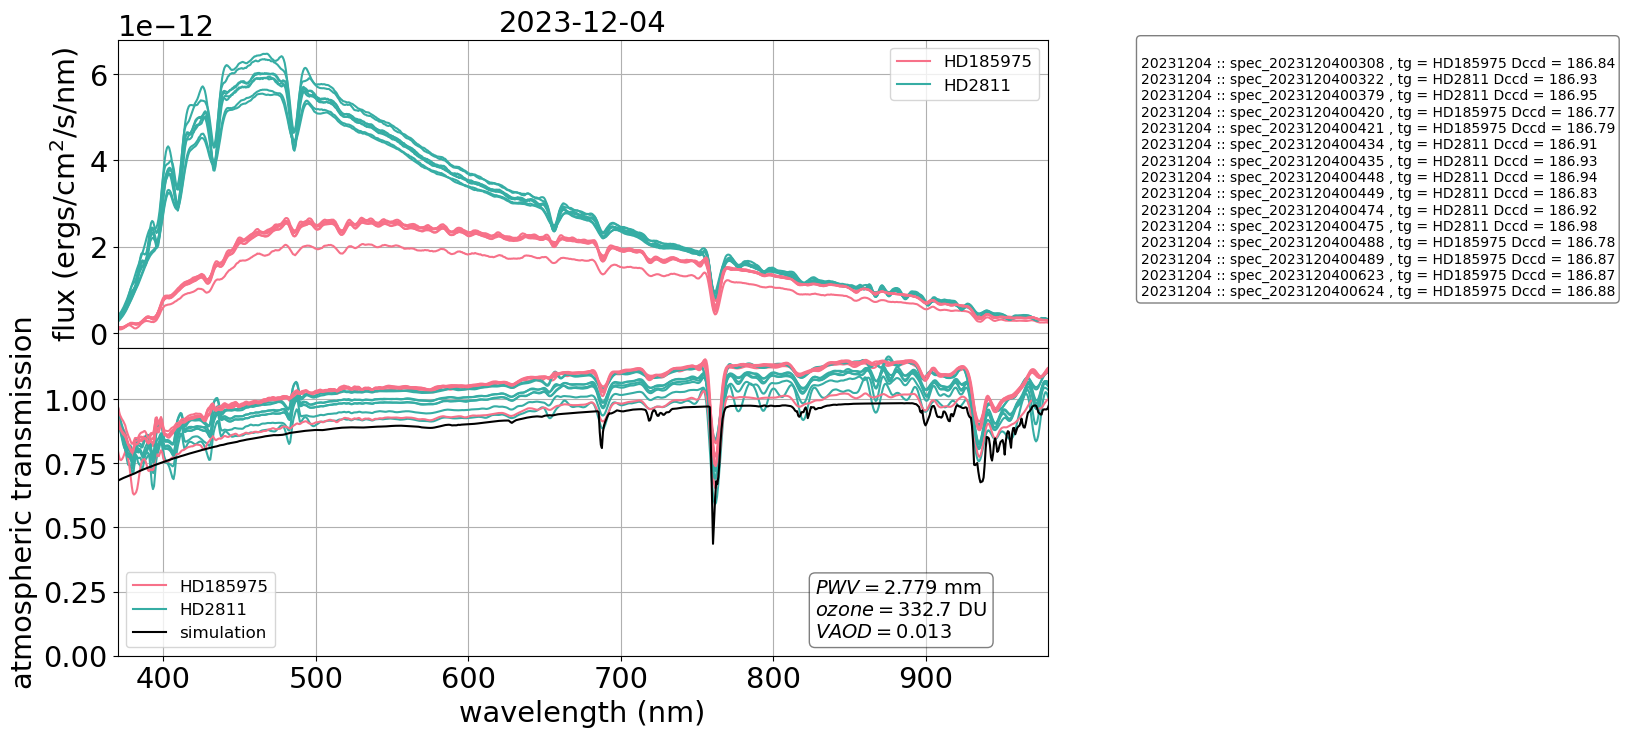

spec_2023120500322 186.8512432334487
spec_2023120500350 186.84862272229253
spec_2023120500382 186.9270410590157
spec_2023120500383 186.90565334933808
spec_2023120500390 186.89453471652948
spec_2023120500434 186.9504849643082


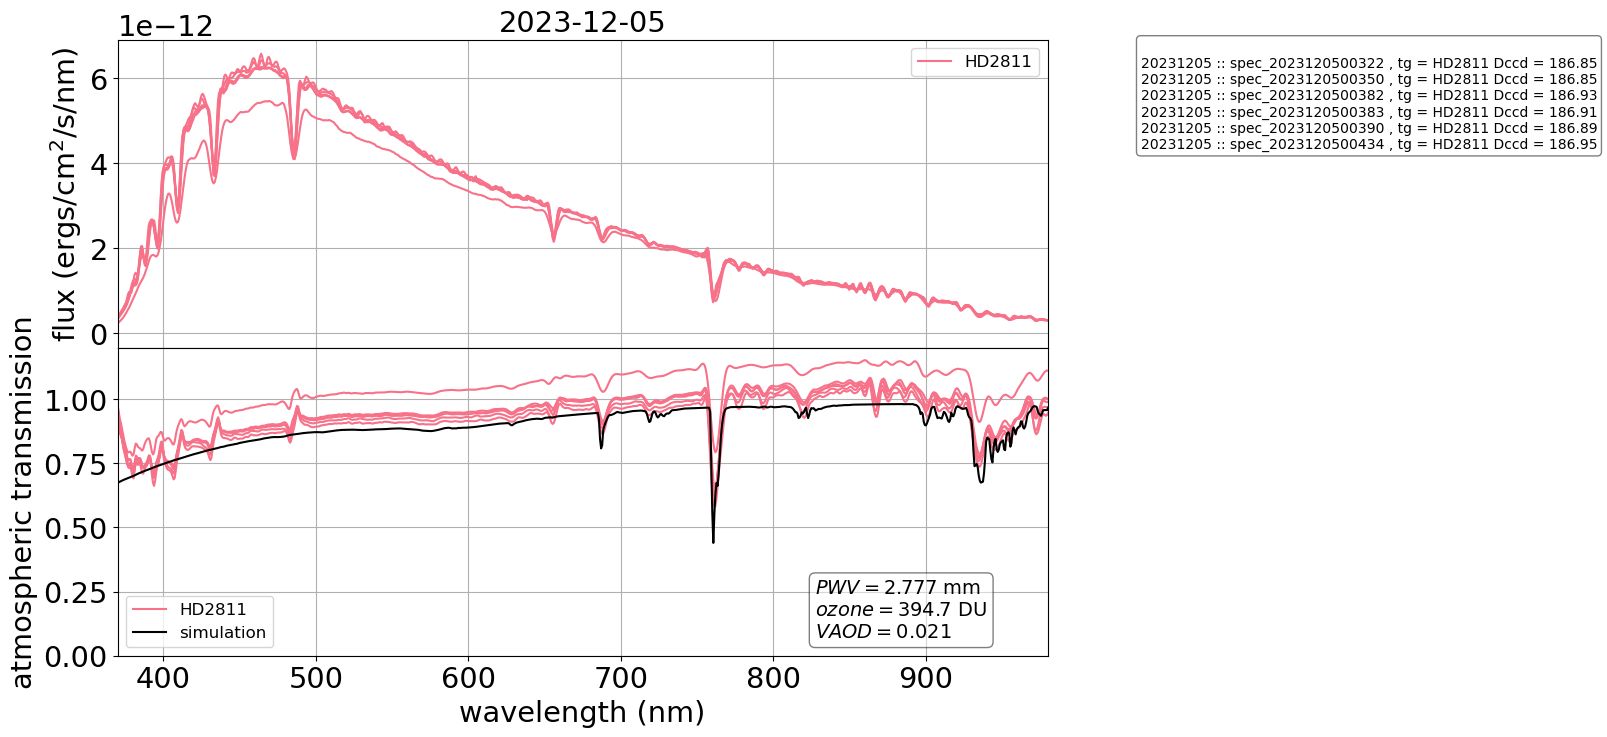

spec_2023120600105 186.94441737935227
spec_2023120600106 186.8522848848898
spec_2023120600134 186.932265134755
spec_2023120600135 186.7974836226421
spec_2023120600190 186.9450494808111
spec_2023120600357 186.8711725405696
spec_2023120600358 186.7595842507722


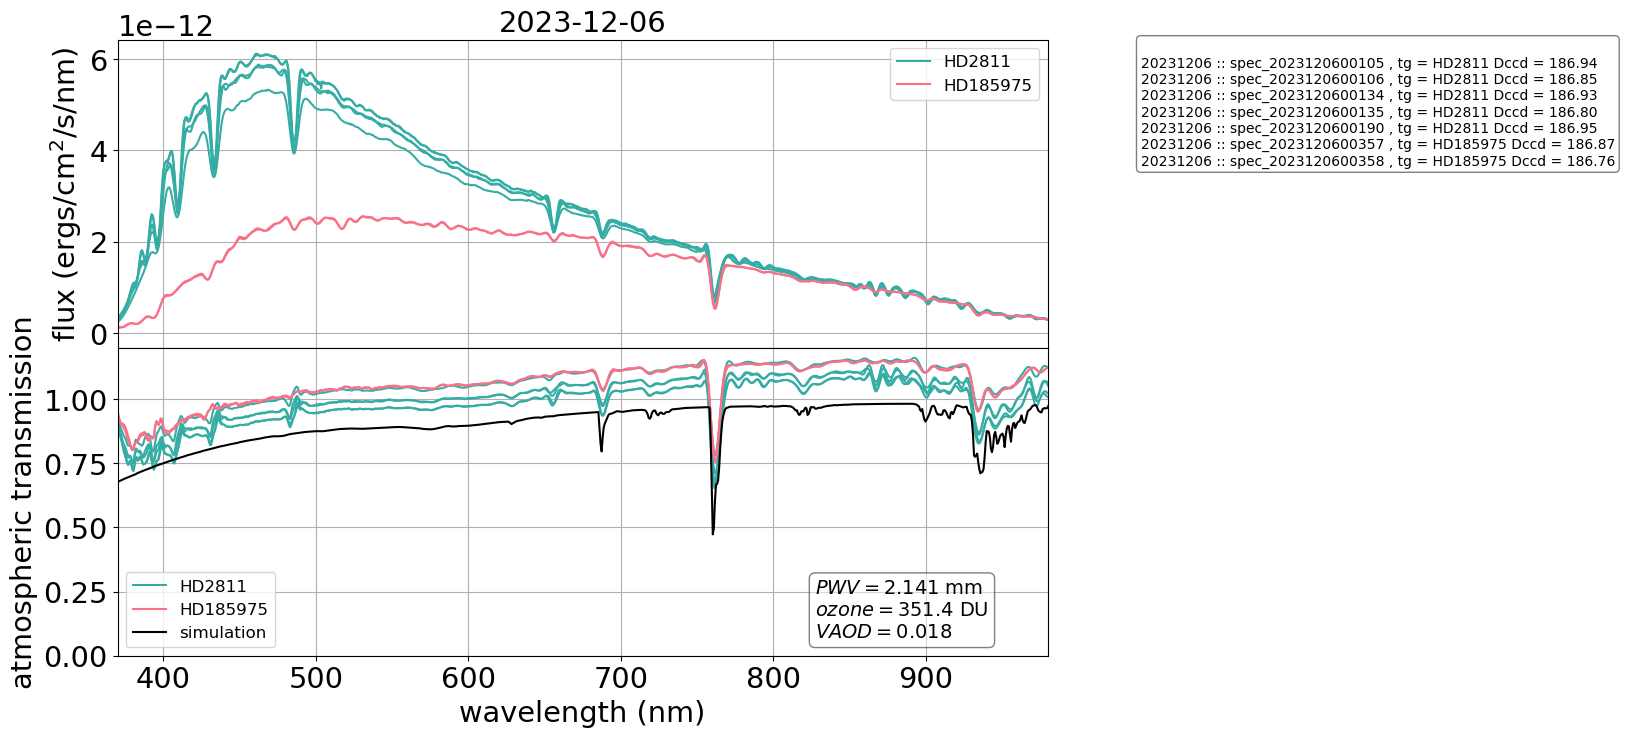

spec_2023120700288 186.89252474819205
spec_2023120700289 186.8378402800759
spec_2023120700317 186.9248435442066
spec_2023120700330 186.83807401695435
spec_2023120700345 186.9371460730847
spec_2023120700358 186.8564549872111
spec_2023120700359 186.8430131348923
spec_2023120700398 186.97199598573528
spec_2023120700399 186.9909880759095
spec_2023120700420 186.8351822953203
spec_2023120700421 186.93502208516128
spec_2023120700434 186.93496739737543
spec_2023120700435 186.8510838314596


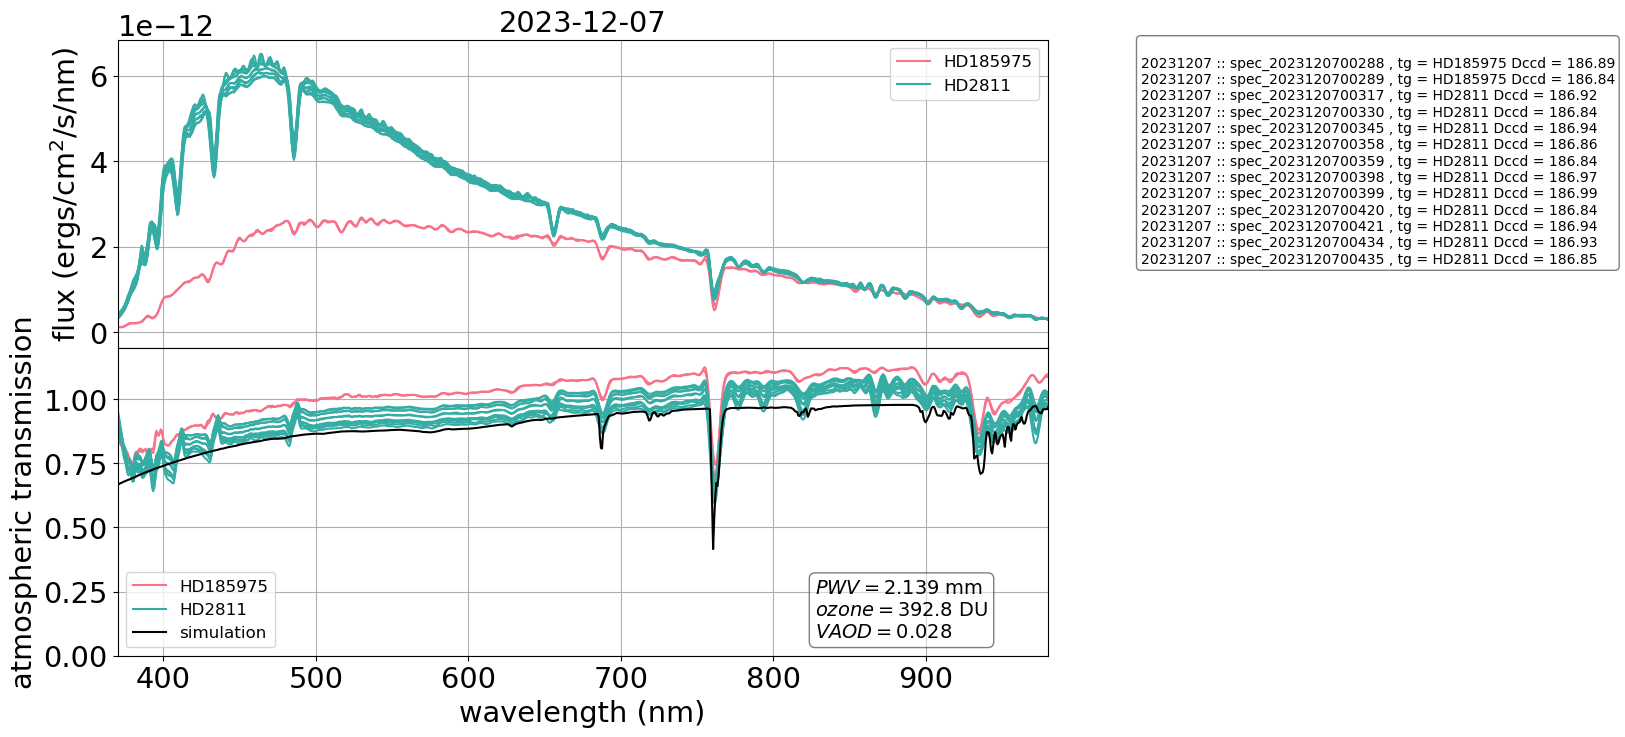

In [28]:
for nightobs in df1.nightobs.unique():
    path = get_spectra_path(nightobs)
    filename = f"spectra_transmission_ratio_{nightobs}.h5"
    fullfilename = os.path.join(path,filename)
    try:
        hf = h5py.File(fullfilename, 'r')
        PlotTransmission(hf,nightobs,df)
        hf.close()
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,

## Apply quality cuts

In [30]:
cut = df["FILTER"] == "empty"
df = df[cut]

In [34]:
list(df.columns)

['id',
 'BITPIX',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'EXTEND',
 'TARGET',
 'REDSHIFT',
 'GRATING',
 'ROTANGLE',
 'D2CCD',
 'LSHIFT',
 'PARANGLE',
 'TARGETX',
 'TARGETY',
 'LBDA_REF',
 'PSF_REG',
 'TRACE_R',
 'MEANFWHM',
 'PIXSHIFT',
 'CHI2_FIT',
 'A2_FIT',
 'AM_FIT',
 'VERSION',
 'CCD_REBIN',
 'CONFIG',
 'EXPTIME',
 'AIRMASS',
 'DEC',
 'HA',
 'OUTTEMP',
 'OUTPRESS',
 'OUTHUM',
 'FILTER',
 'CAM_ROT',
 'S_X0',
 'S_Y0',
 'S_XMIN',
 'S_XMAX',
 'S_YMIN',
 'S_YMAX',
 'S_NX',
 'S_NY',
 'S_DEG',
 'S_SAT',
 'S_ORDER',
 'A1_x',
 'A1_err_x',
 'A2_x',
 'A2_err_x',
 'A3',
 'A3_err',
 'VAOD_x',
 'VAOD_err_x',
 'angstrom_exp_x',
 'angstrom_exp_err_x',
 'ozone [db]_x',
 'ozone [db]_err_x',
 'PWV [mm]_x',
 'PWV [mm]_err_x',
 'D_CCD [mm]_x',
 'D_CCD [mm]_err_x',
 'shift_x [pix]',
 'shift_x [pix]_err',
 'shift_y [pix]',
 'shift_y [pix]_err',
 'angle [deg]',
 'angle [deg]_err',
 'B_x',
 'B_err_x',
 'A_star',
 'A_star_err',
 'x_c_0_1',
 'x_c_0_1_err',
 'x_c_1_1',
 'x_c_1_1_err',
 'x_c_2_1',
 'x_c_2_1_err',
 

In [31]:
# convert pandas to numpy rec array
rec = df.to_records()

In [35]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [nm]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

465
456
437
423
423
422


In [36]:
stars = np.unique(rec["TARGET"])
stars

array(['HD009051', 'HD14943', 'HD160617', 'HD167060', 'HD185975',
       'HD200654', 'HD205905', 'HD2811', 'HD38666'], dtype=object)

In [37]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

## Plot

In [38]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.1,1.9]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,12.]
ATMMINMAX["VAOD_y"] = [0.,0.5]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.5,1.5]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,12.]
ATMMINMAX["VAOD_x"] = [0.,0.5]
ATMMINMAX["A2_x"] = [0.7,1.3]

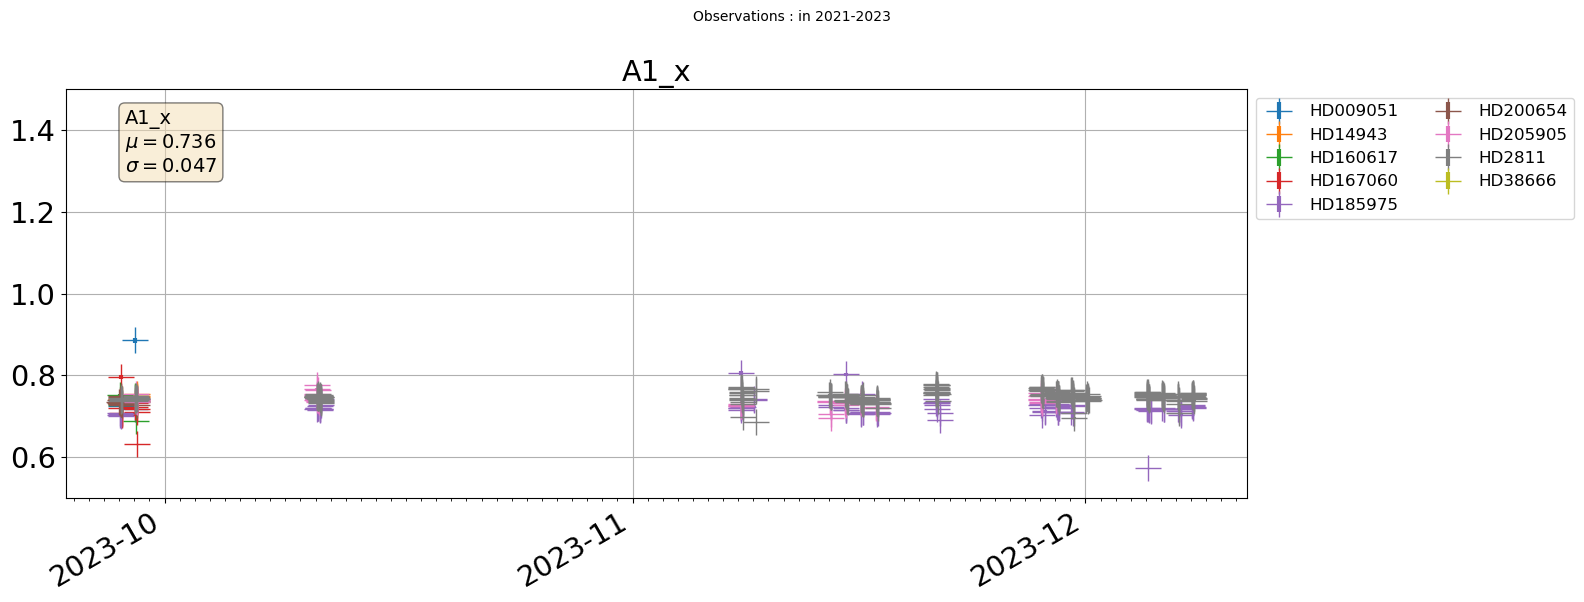

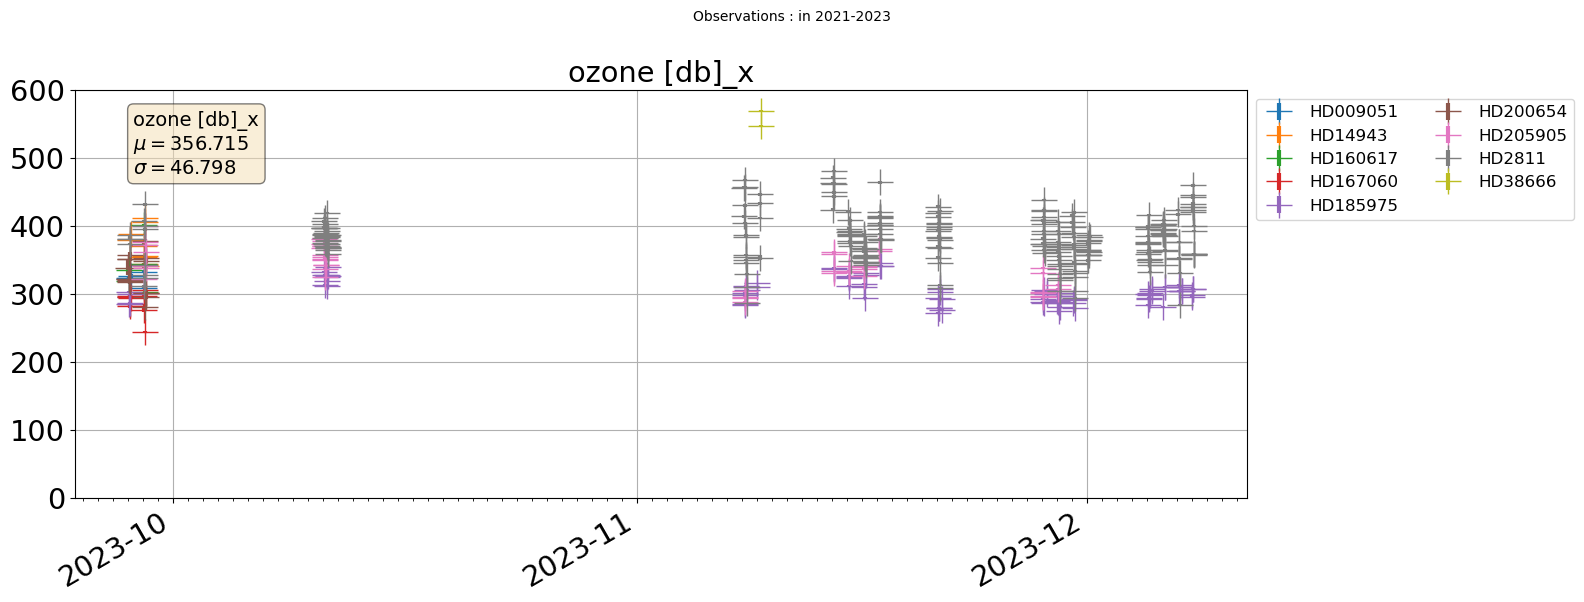

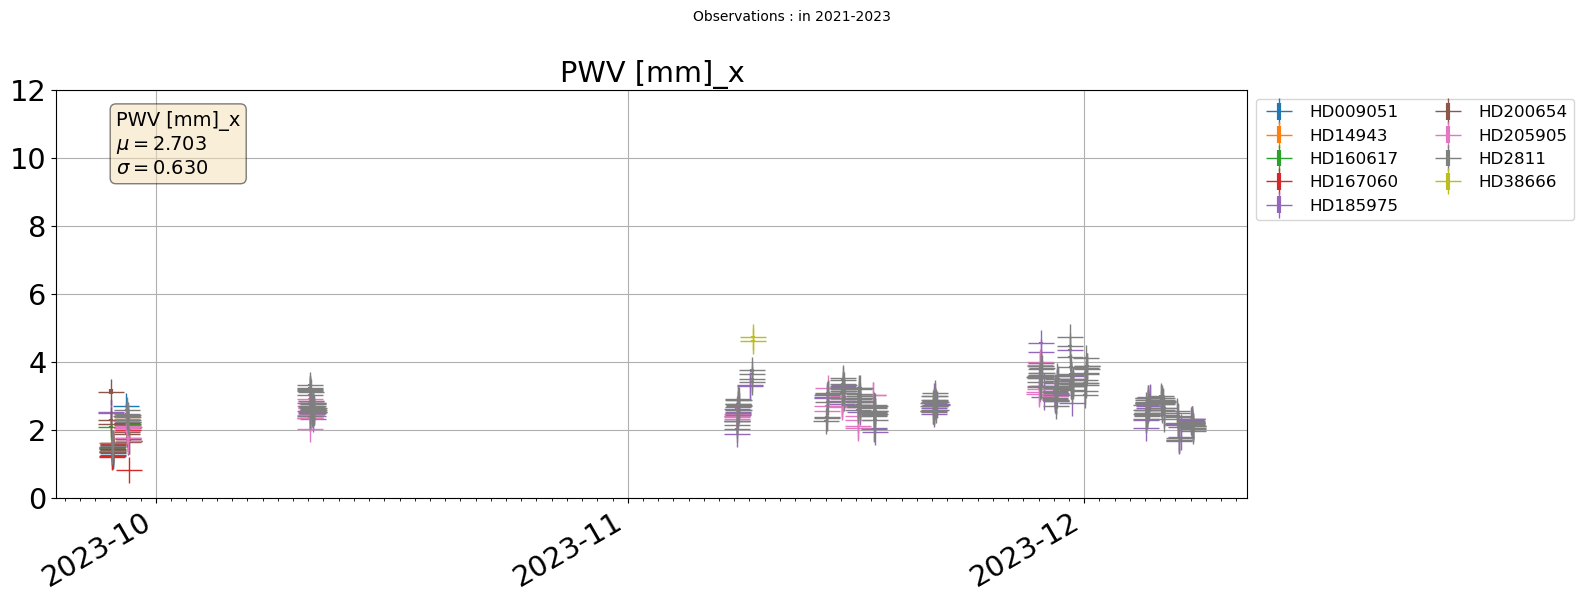

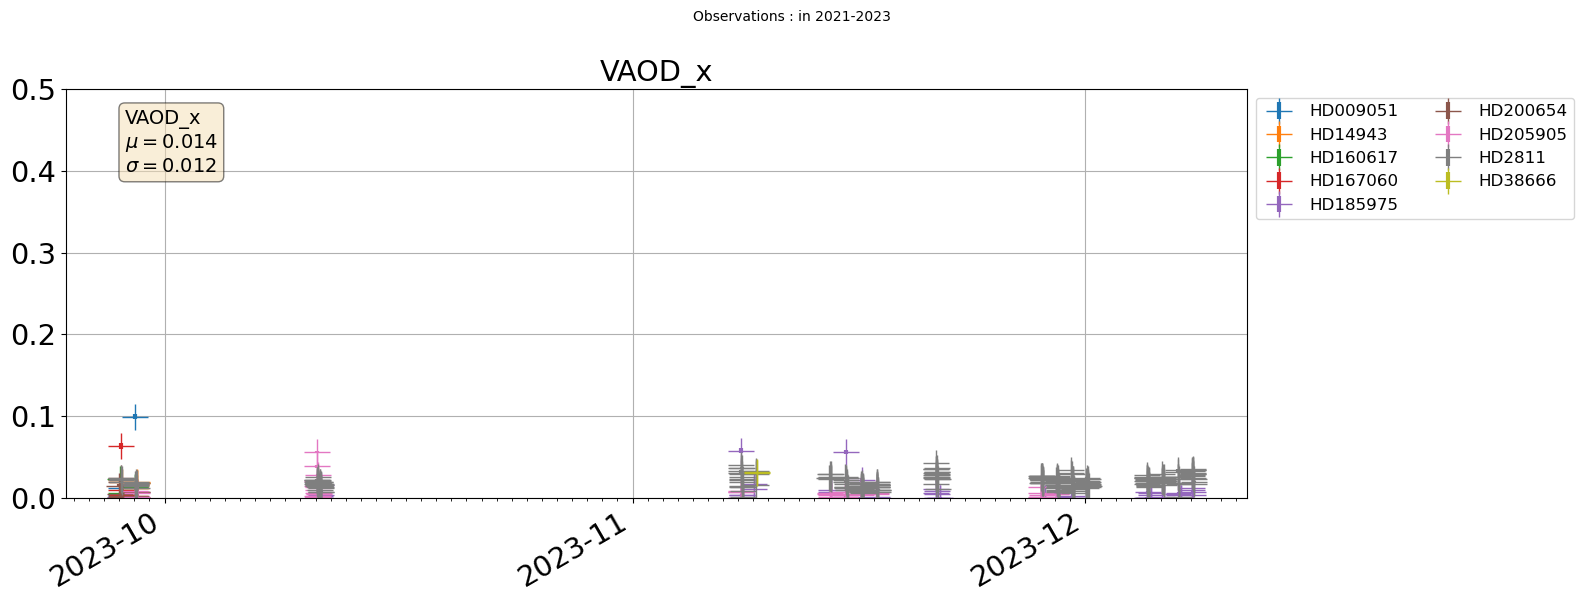

In [39]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

## Merra2

    MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv

In [40]:
top_merra2 = "../../../Merra2"

In [41]:
asm_merra2 = [
    #"MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
    #"MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv"]
Nasm = len(asm_merra2)

In [42]:
aer_merra2 = [
    #"MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
    #"MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv"]
Naer = len(aer_merra2)

In [43]:
df_asm = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in asm_merra2] 
df_aer = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in aer_merra2] 

In [44]:
df_asm[0].head()

PS       T10M        T2M        TO3       TOX  \
time                                                                        
2023-01-01 00:00:00  78620.320  284.24590  284.19403  267.12990  0.005727   
2023-01-01 01:00:00  78645.195  282.94003  282.63483  267.16120  0.005727   
2023-01-01 02:00:00  78658.790  282.69012  281.91070  266.89362  0.005721   
2023-01-01 03:00:00  78664.510  282.95117  281.80444  266.16187  0.005706   
2023-01-01 04:00:00  78652.450  283.03754  281.62714  265.97803  0.005702   

                     TQI           TQL       TQV         TS      U10M  \
time                                                                    
2023-01-01 00:00:00  0.0  2.642721e-05  5.599337  283.92380  1.750564   
2023-01-01 01:00:00  0.0  7.297844e-06  4.944884  282.22986  0.164982   
2023-01-01 02:00:00  0.0  1.972541e-06  4.232842  280.79850 -0.738192   
2023-01-01 03:00:00  0.0  5.257316e-07  3.744954  279.49896 -0.444341   
2023-01-01 04:00:00  0.0  9.333598e-08  3.388126  278.33760 -0.331920   

                          U2M      U50M      V10M       V2M      V50M  
time                                                                   
2023-01-01 00:00:00  1.238044  2.038036 -0.090943 -0.012991 -0.419707  
2023-01-01 01:00:00  0.114584  0.112569  0.002039  0.040294 -0.018076  
2023-01-01 02:00:00 -0.392655 -0.988660 -0.194765 -0.107497 -0.264359  
2023-01-01 03:00:00 -0.294611 -0.499962 -0.778797 -0.391749 -1.194732  
2023-01-01 04:00:00 -0.232934 -0.348620 -1.210167 -0.640487 -1.799269

In [45]:
df_aer[0].head()

TOTANGSTR  TOTEXTTAU  TOTSCATAU
time                                                
2023-01-01 00:30:00   1.344682   0.048491   0.045733
2023-01-01 01:30:00   1.363253   0.044516   0.041716
2023-01-01 02:30:00   1.378122   0.040857   0.038042
2023-01-01 03:30:00   1.392257   0.038250   0.035439
2023-01-01 04:30:00   1.408844   0.036092   0.033277

In [46]:
df_asm[0].index

Index(['2023-01-01 00:00:00', '2023-01-01 01:00:00', '2023-01-01 02:00:00',
       '2023-01-01 03:00:00', '2023-01-01 04:00:00', '2023-01-01 05:00:00',
       '2023-01-01 06:00:00', '2023-01-01 07:00:00', '2023-01-01 08:00:00',
       '2023-01-01 09:00:00',
       ...
       '2023-12-31 14:00:00', '2023-12-31 15:00:00', '2023-12-31 16:00:00',
       '2023-12-31 17:00:00', '2023-12-31 18:00:00', '2023-12-31 19:00:00',
       '2023-12-31 20:00:00', '2023-12-31 21:00:00', '2023-12-31 22:00:00',
       '2023-12-31 23:00:00'],
      dtype='object', name='time', length=8760)

Text(0.5, 1.0, 'Merra2 Ozone')

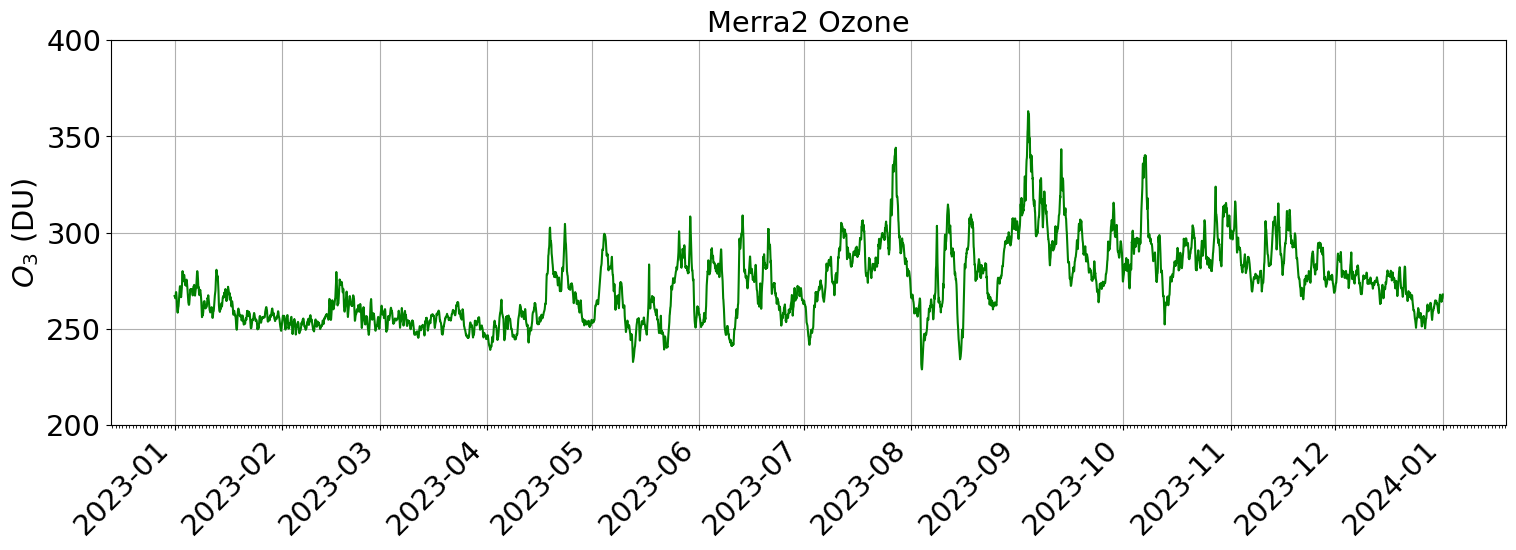

In [47]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'g-')
#ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'r-')
#ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');
ax.set_ylim(200.,400.)
ax.set_ylabel("$O_3$ (DU)")
ax.set_title("Merra2 Ozone")



In [48]:
df["dateobs"].values

array(['2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-09-27

Text(0.5, 1.0, 'Merra2 Precipitable Water Vapor')

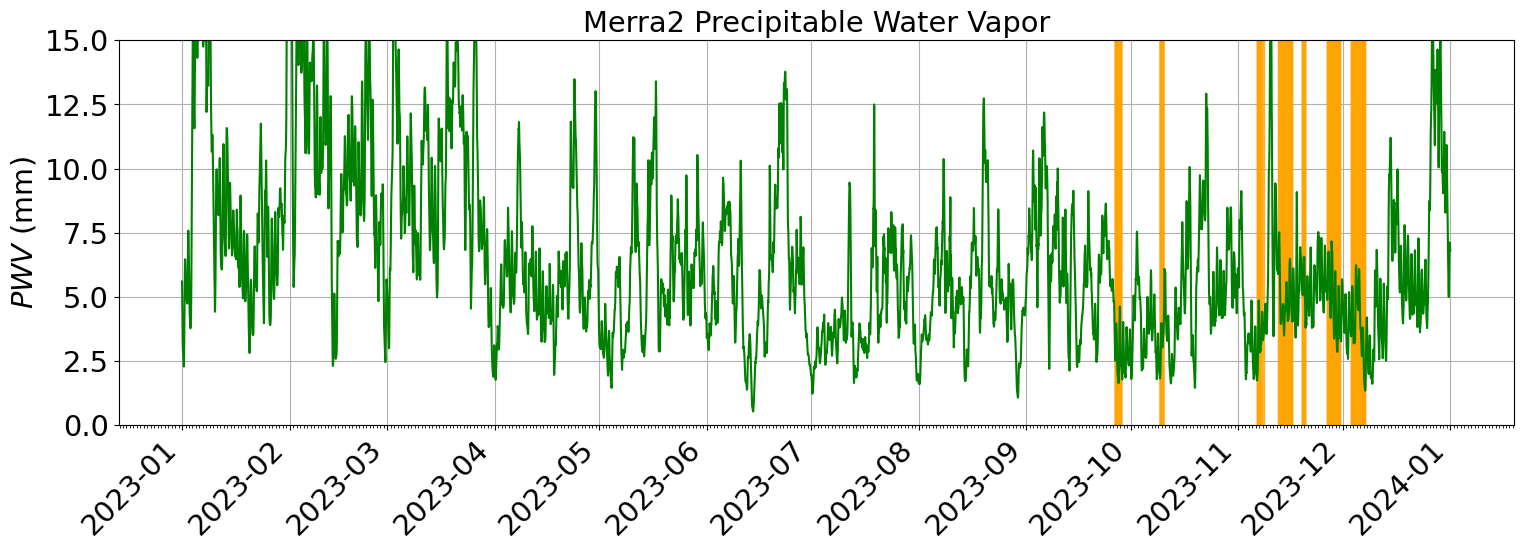

In [49]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

for dateobs in df["dateobs"]:
    ax.axvline(dateobs,color="orange",lw=3,alpha=0.2)

ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'g-')
#ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'r-')
#ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,15.)
ax.set_ylabel("$PWV$ (mm)")
ax.set_title("Merra2 Precipitable Water Vapor")


Text(0.5, 1.0, 'Merra2 Aerosol Extinction')

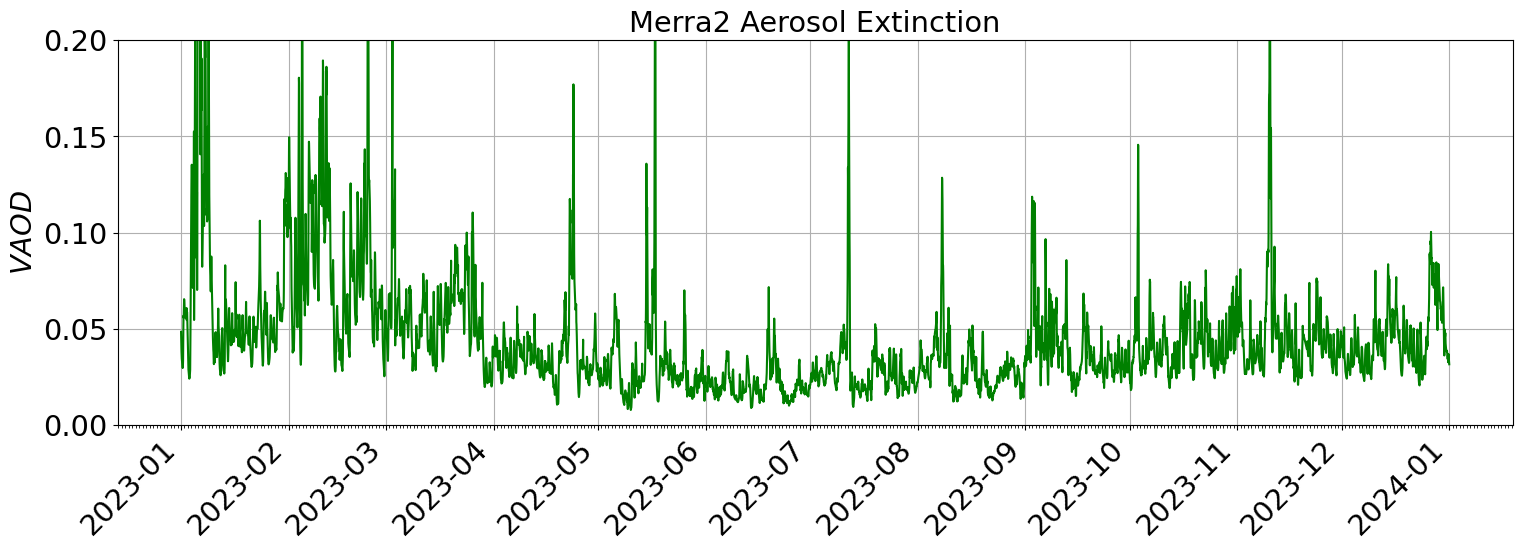

In [50]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTEXTTAU,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTEXTTAU,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTEXTTAU,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Extinction")

Text(0.5, 1.0, 'Merra2 Aerosol Scattering')

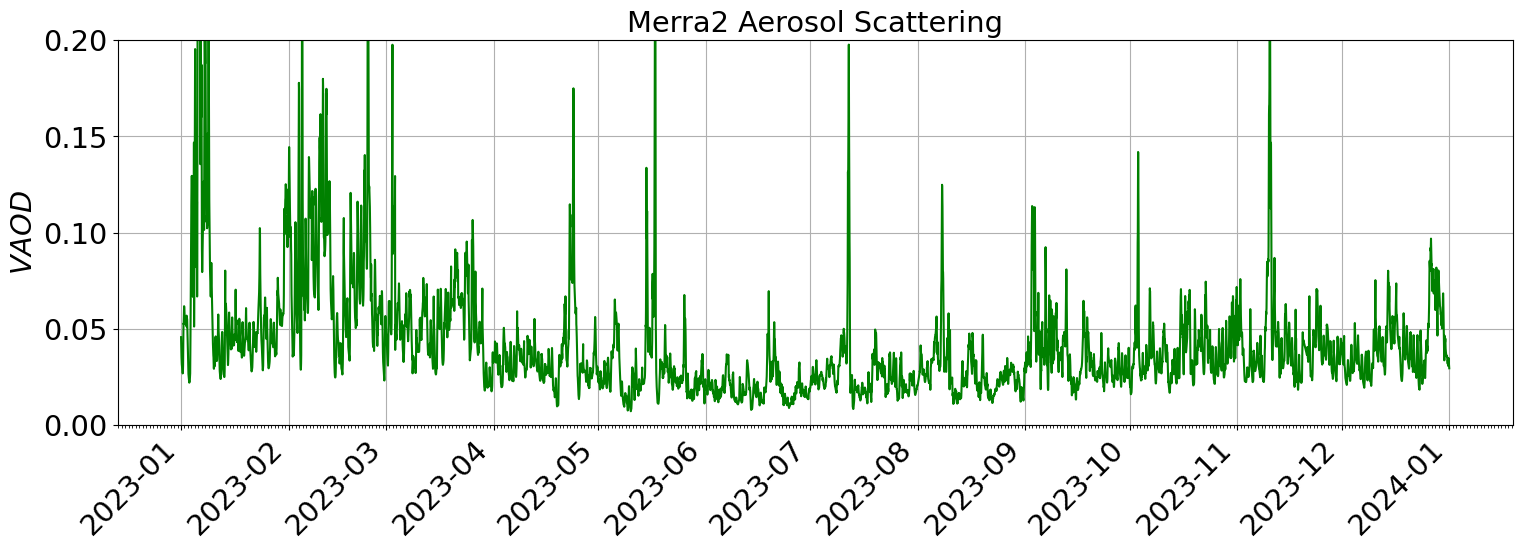

In [51]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

    
ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTSCATAU,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTSCATAU,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTSCATAU,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Scattering")

Text(0.5, 1.0, 'Merra2 Aerosol exponent')

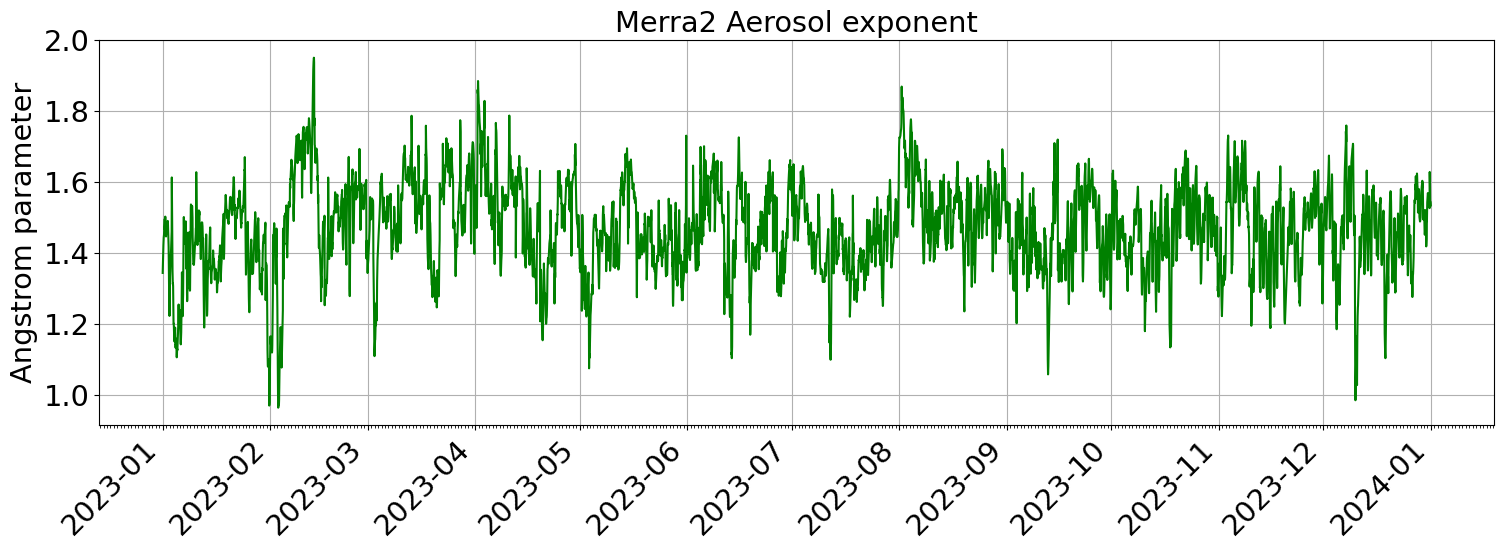

In [52]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTANGSTR,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTANGSTR,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTANGSTR,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

#ax.set_ylim(0.,2.)
ax.set_ylabel("Angstrom parameter")
ax.set_title("Merra2 Aerosol exponent")

## Ozone

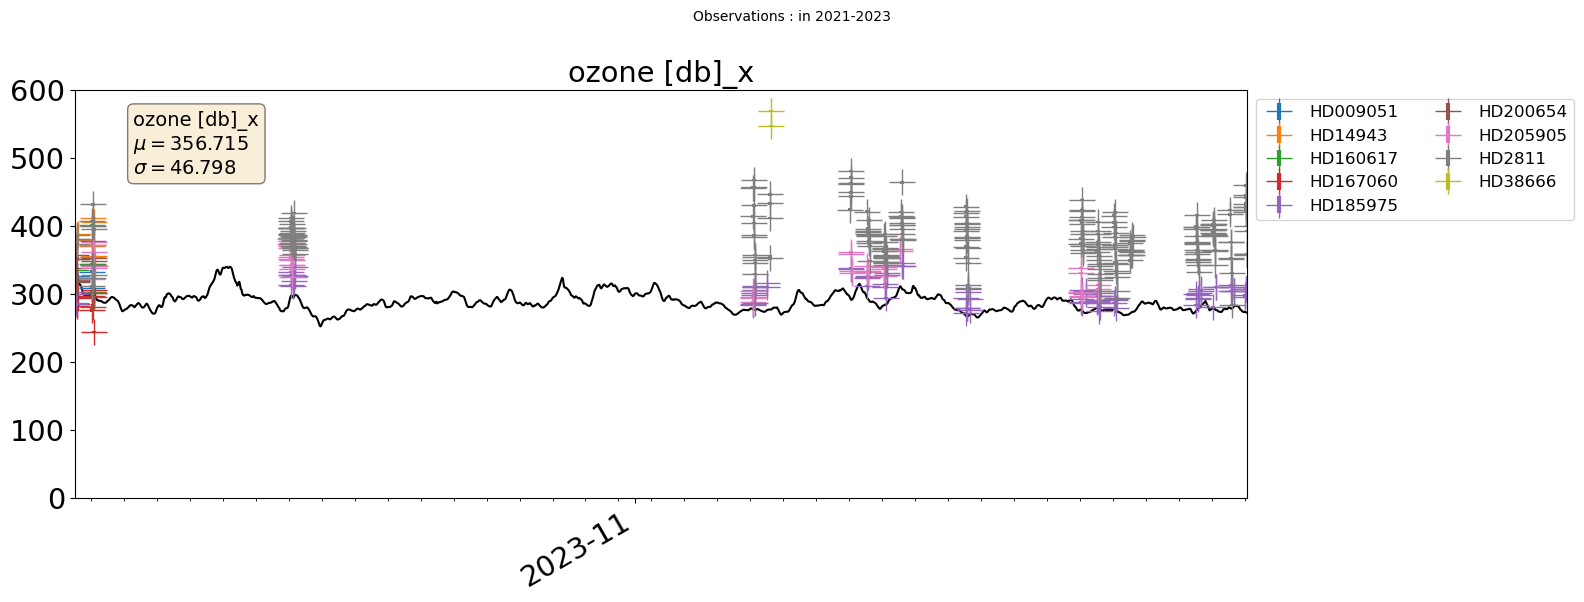

In [59]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=2)
day_locator = mdates.DayLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["ozone [db]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'k-')
    ax.set_xlim(pd.to_datetime(rec["DATE-OBS"][0]),pd.to_datetime(rec["DATE-OBS"][-1] ))
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

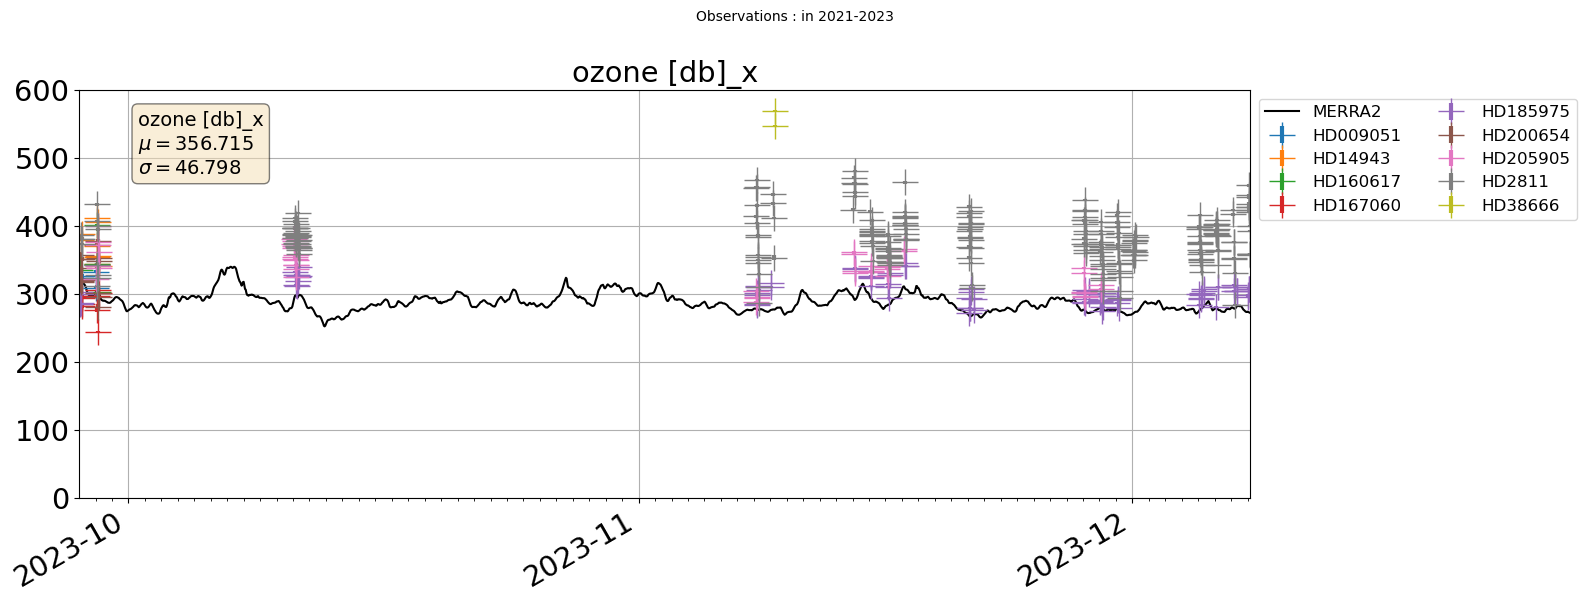

In [60]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["ozone [db]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'k-',label="MERRA2")
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'k-')
    #ax.set_xlim(pd.to_datetime('2023-08-01 00:00:00'),pd.to_datetime('2024-01-01 00:00:00'))
    ax.set_xlim(pd.to_datetime(rec["DATE-OBS"][0]),pd.to_datetime(rec["DATE-OBS"][-1] ))
    ax.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

## PWV

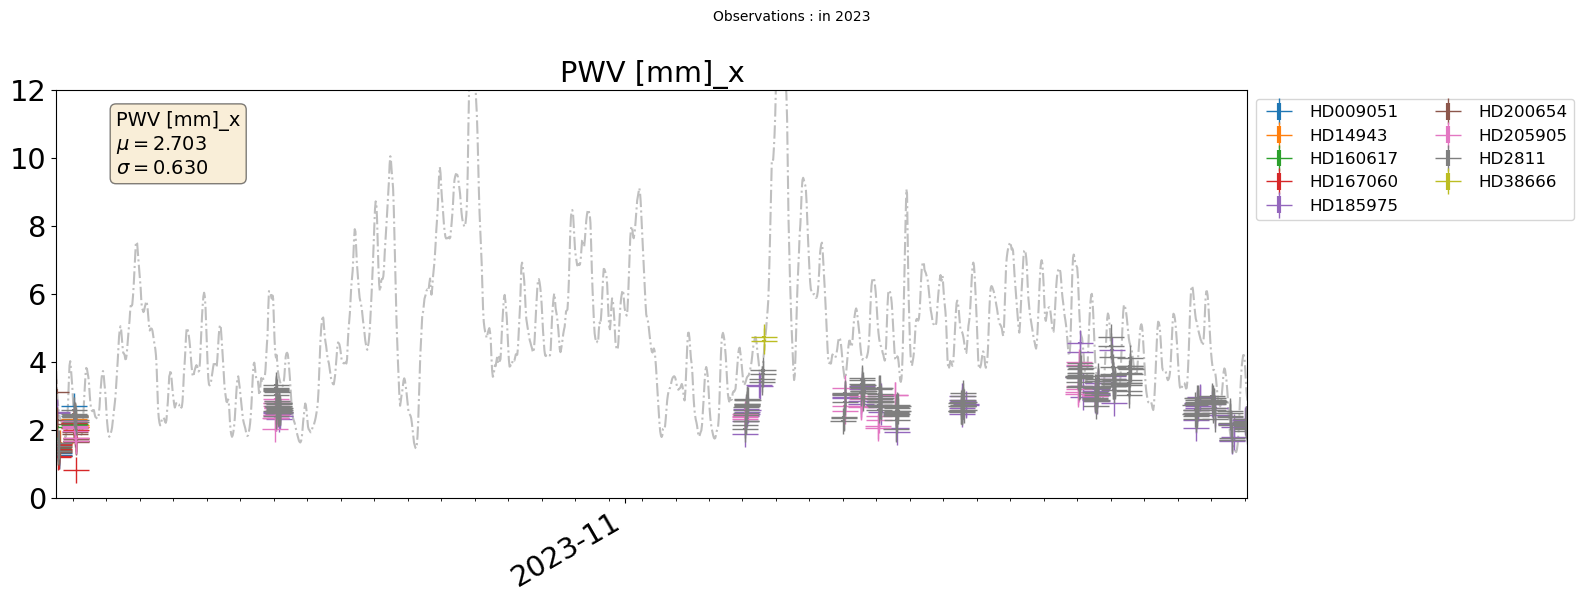

In [62]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=2)
day_locator = mdates.DayLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["PWV [mm]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'-.',color="grey",alpha=0.5)
    ax.set_xlim(pd.to_datetime(rec["DATE-OBS"][0]),pd.to_datetime(rec["DATE-OBS"][-1] ))
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

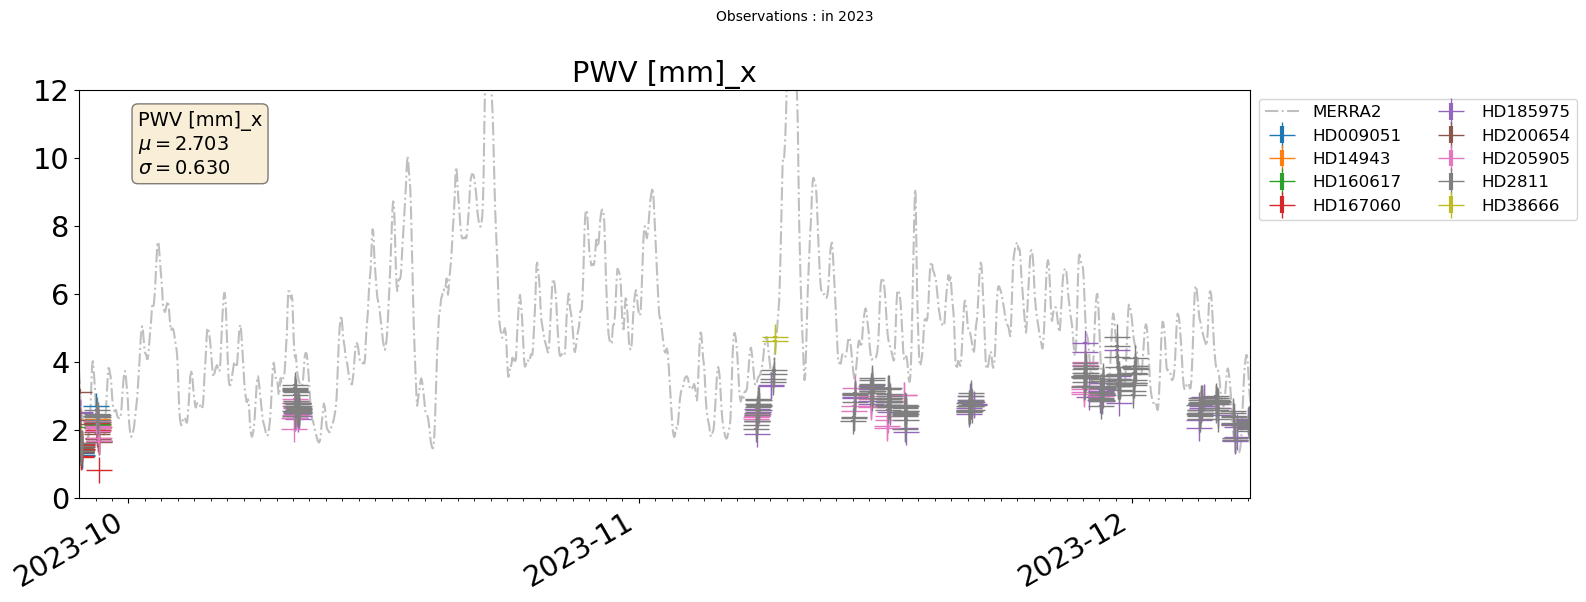

In [63]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["PWV [mm]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'-.',color="grey",alpha=0.5,label="MERRA2")
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'-.',color="grey",alpha=0.5)
   
    ax.set_xlim(pd.to_datetime(rec["DATE-OBS"][0]),pd.to_datetime(rec["DATE-OBS"][-1] ))
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()